In [1]:
# !pip install rlds dm-reverb[tensorflow]
# !pip install flax jax

In [2]:
# @title Imports

from typing import Any, Callable, Dict, Optional, Sequence, Union, NamedTuple, Tuple

import copy
import enum
import flax
import flax.linen as nn
import jax
from jax.experimental import mesh_utils
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import rlds
import reverb
from rlds import transformations
import tensorflow_datasets as tfds
import tree

import abc
import dataclasses
import math
from typing import Dict, Optional

from rlds import rlds_types
import tensorflow as tf
from PIL import Image
from IPython import display
import tensorflow_datasets as tfds
import functools
from typing import Callable, Sequence
import matplotlib.pyplot as plt
from flax.training import checkpoints

import os
import shutil


2024-06-21 15:22:32.189305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 15:22:32.189322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 15:22:32.189825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-21 15:22:32.558103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Pipeline

In [3]:
# @title Transformation definitions

# For an example usage of the code in this code cell, please take a look at the
# dataset colab at the link below:
# https://colab.research.google.com/github/google-deepmind/open_x_embodiment/blob/main/colabs/Open_X_Embodiment_Datasets.ipynb

def _features_to_tensor_spec(
    feature: tfds.features.FeatureConnector
) -> tf.TensorSpec:
  """Converts a tfds Feature into a TensorSpec."""

  def _get_feature_spec(nested_feature: tfds.features.FeatureConnector):
    if isinstance(nested_feature, tf.DType):
      return tf.TensorSpec(shape=(), dtype=nested_feature)
    else:
      return nested_feature.get_tensor_spec()

  # FeaturesDict can sometimes be a plain dictionary, so we use tf.nest to
  # make sure we deal with the nested structure.
  return tf.nest.map_structure(_get_feature_spec, feature)


def _encoded_feature(feature: Optional[tfds.features.FeatureConnector],
                     image_encoding: Optional[str],
                     tensor_encoding: Optional[tfds.features.Encoding]):
  """Adds encoding to Images and/or Tensors."""
  def _apply_encoding(feature: tfds.features.FeatureConnector,
                      image_encoding: Optional[str],
                      tensor_encoding: Optional[tfds.features.Encoding]):
    if image_encoding and isinstance(feature, tfds.features.Image):
      return tfds.features.Image(
          shape=feature.shape,
          dtype=feature.dtype,
          use_colormap=feature.use_colormap,
          encoding_format=image_encoding)
    if tensor_encoding and isinstance(
        feature, tfds.features.Tensor) and feature.dtype != tf.string:
      return tfds.features.Tensor(
          shape=feature.shape, dtype=feature.dtype, encoding=tensor_encoding)
    return feature

  if not feature:
    return None
  return tf.nest.map_structure(
      lambda x: _apply_encoding(x, image_encoding, tensor_encoding), feature)


@dataclasses.dataclass
class RLDSSpec(metaclass=abc.ABCMeta):
  """Specification of an RLDS Dataset.

  It is used to hold a spec that can be converted into a TFDS DatasetInfo or
  a `tf.data.Dataset` spec.
  """
  observation_info: Optional[tfds.features.FeatureConnector] = None
  action_info: Optional[tfds.features.FeatureConnector] = None
  reward_info: Optional[tfds.features.FeatureConnector] = None
  discount_info: Optional[tfds.features.FeatureConnector] = None
  step_metadata_info: Optional[tfds.features.FeaturesDict] = None
  episode_metadata_info: Optional[tfds.features.FeaturesDict] = None

  def step_tensor_spec(self) -> Dict[str, tf.TensorSpec]:
    """Obtains the TensorSpec of an RLDS step."""
    step = {}
    if self.observation_info:
      step[rlds_types.OBSERVATION] = _features_to_tensor_spec(
          self.observation_info)
    if self.action_info:
      step[rlds_types.ACTION] = _features_to_tensor_spec(
          self.action_info)
    if self.discount_info:
      step[rlds_types.DISCOUNT] = _features_to_tensor_spec(
          self.discount_info)
    if self.reward_info:
      step[rlds_types.REWARD] = _features_to_tensor_spec(
          self.reward_info)
    if self.step_metadata_info:
      for k, v in self.step_metadata_info.items():
        step[k] = _features_to_tensor_spec(v)

    step[rlds_types.IS_FIRST] = tf.TensorSpec(shape=(), dtype=bool)
    step[rlds_types.IS_LAST] = tf.TensorSpec(shape=(), dtype=bool)
    step[rlds_types.IS_TERMINAL] = tf.TensorSpec(shape=(), dtype=bool)
    return step

  def episode_tensor_spec(self) -> Dict[str, tf.TensorSpec]:
    """Obtains the TensorSpec of an RLDS step."""
    episode = {}
    episode[rlds_types.STEPS] = tf.data.DatasetSpec(
        element_spec=self.step_tensor_spec())
    if self.episode_metadata_info:
      for k, v in self.episode_metadata_info.items():
        episode[k] = _features_to_tensor_spec(v)
    return episode

  def to_dataset_config(
      self,
      name: str,
      image_encoding: Optional[str] = None,
      tensor_encoding: Optional[tfds.features.Encoding] = None,
      citation: Optional[str] = None,
      homepage: Optional[str] = None,
      description: Optional[str] = None,
      overall_description: Optional[str] = None,
  ) -> tfds.rlds.rlds_base.DatasetConfig:
    """Obtains the DatasetConfig for TFDS from the Spec."""
    return tfds.rlds.rlds_base.DatasetConfig(
        name=name,
        description=description,
        overall_description=overall_description,
        homepage=homepage,
        citation=citation,
        observation_info=_encoded_feature(self.observation_info, image_encoding,
                                          tensor_encoding),
        action_info=_encoded_feature(self.action_info, image_encoding,
                                     tensor_encoding),
        reward_info=_encoded_feature(self.reward_info, image_encoding,
                                     tensor_encoding),
        discount_info=_encoded_feature(self.discount_info, image_encoding,
                                       tensor_encoding),
        step_metadata_info=_encoded_feature(self.step_metadata_info,
                                            image_encoding, tensor_encoding),
        episode_metadata_info=_encoded_feature(self.episode_metadata_info,
                                               image_encoding, tensor_encoding))

  def to_features_dict(self):
    """Returns a TFDS FeaturesDict representing the dataset config."""
    step_config = {
        rlds_types.IS_FIRST: tf.bool,
        rlds_types.IS_LAST: tf.bool,
        rlds_types.IS_TERMINAL: tf.bool,
    }

    if self.observation_info:
      step_config[rlds_types.OBSERVATION] = self.observation_info
    if self.action_info:
      step_config[rlds_types.ACTION] = self.action_info
    if self.discount_info:
      step_config[rlds_types.DISCOUNT] = self.discount_info
    if self.reward_info:
      step_config[rlds_types.REWARD] = self.reward_info

    if self.step_metadata_info:
      for k, v in self.step_metadata_info.items():
        step_config[k] = v

    if self.episode_metadata_info:
      return tfds.features.FeaturesDict({
          rlds_types.STEPS: tfds.features.Dataset(step_config),
          **self.episode_metadata_info,
      })
    else:
      return tfds.features.FeaturesDict({
          rlds_types.STEPS: tfds.features.Dataset(step_config),
      })

RLDS_SPEC = RLDSSpec
TENSOR_SPEC = Union[tf.TensorSpec, dict[str, tf.TensorSpec]]


@dataclasses.dataclass
class TrajectoryTransform(metaclass=abc.ABCMeta):
  """Specification the TrajectoryTransform applied to a dataset of episodes.

  A TrajectoryTransform is a set of rules transforming a dataset
  of RLDS episodes to a dataset of trajectories.
  This involves three distinct stages:
  - An optional `episode_to_steps_map_fn(episode)` is called at the episode
    level, and can be used to select or modify steps.
    - Augmentation: an `episode_key` could be propagated to `steps` for
      debugging.
    - Selection: Particular steps can be selected.
    - Stripping: Features can be removed from steps. Prefer using `step_map_fn`.
  - An optional `step_map_fn` is called at the flattened steps dataset for each
    step, and can be used to featurize a step, e.g. add/remove features, or
    augument images
  - A `pattern` leverages DM patterns to set a rule of slicing an episode to a
    dataset of overlapping trajectories.

  Importantly, each TrajectoryTransform must define a `expected_tensor_spec`
  which specifies a nested TensorSpec of the resulting dataset. This is what
  this TrajectoryTransform will produce, and can be used as an interface with
  a neural network.
  """
  episode_dataset_spec: RLDS_SPEC
  episode_to_steps_fn_dataset_spec: RLDS_SPEC
  steps_dataset_spec: Any
  pattern: reverb.structured_writer.Pattern
  episode_to_steps_map_fn: Any
  expected_tensor_spec: TENSOR_SPEC
  step_map_fn: Optional[Any] = None

  def get_for_cached_trajectory_transform(self):
    """Creates a copy of this traj transform to use with caching.

    The returned TrajectoryTransfrom copy will be initialized with the default
    version of the `episode_to_steps_map_fn`, because the effect of that
    function has already been materialized in the cached copy of the dataset.
    Returns:
      trajectory_transform: A copy of the TrajectoryTransform with overridden
        `episode_to_steps_map_fn`.
    """
    traj_copy = dataclasses.replace(self)
    traj_copy.episode_dataset_spec = traj_copy.episode_to_steps_fn_dataset_spec
    traj_copy.episode_to_steps_map_fn = lambda e: e[rlds_types.STEPS]
    return traj_copy

  def transform_episodic_rlds_dataset(self, episodes_dataset: tf.data.Dataset):
    """Applies this TrajectoryTransform to the dataset of episodes."""

    # Convert the dataset of episodes to the dataset of steps.
    steps_dataset = episodes_dataset.map(
        self.episode_to_steps_map_fn, num_parallel_calls=tf.data.AUTOTUNE
    ).flat_map(lambda x: x)

    return self._create_pattern_dataset(steps_dataset)

  def transform_steps_rlds_dataset(
      self, steps_dataset: tf.data.Dataset
  ) -> tf.data.Dataset:
    """Applies this TrajectoryTransform to the dataset of episode steps."""

    return self._create_pattern_dataset(steps_dataset)

  def create_test_dataset(
      self,
  ) -> tf.data.Dataset:
    """Creates a test dataset of trajectories.

    It is guaranteed that the structure of this dataset will be the same as
    when flowing real data. Hence this is a useful construct for tests or
    initialization of JAX models.
    Returns:
      dataset: A test dataset made of zeros structurally identical to the
        target dataset of trajectories.
    """
    zeros = transformations.zeros_from_spec(self.expected_tensor_spec)

    return tf.data.Dataset.from_tensors(zeros)

  def _create_pattern_dataset(
      self, steps_dataset: tf.data.Dataset) -> tf.data.Dataset:
    """Create PatternDataset from the `steps_dataset`."""
    config = create_structured_writer_config('temp', self.pattern)

    # Further transform each step if the `step_map_fn` is provided.
    if self.step_map_fn:
      steps_dataset = steps_dataset.map(self.step_map_fn)
    pattern_dataset = reverb.PatternDataset(
        input_dataset=steps_dataset,
        configs=[config],
        respect_episode_boundaries=True,
        is_end_of_episode=lambda x: x[rlds_types.IS_LAST])
    return pattern_dataset


class TrajectoryTransformBuilder(object):
  """Facilitates creation of the `TrajectoryTransform`."""

  def __init__(self,
               dataset_spec: RLDS_SPEC,
               episode_to_steps_map_fn=lambda e: e[rlds_types.STEPS],
               step_map_fn=None,
               pattern_fn=None,
               expected_tensor_spec=None):
    self._rds_dataset_spec = dataset_spec
    self._steps_spec = None
    self._episode_to_steps_map_fn = episode_to_steps_map_fn
    self._step_map_fn = step_map_fn
    self._pattern_fn = pattern_fn
    self._expected_tensor_spec = expected_tensor_spec

  def build(self,
            validate_expected_tensor_spec: bool = True) -> TrajectoryTransform:
    """Creates `TrajectoryTransform` from a `TrajectoryTransformBuilder`."""

    if validate_expected_tensor_spec and self._expected_tensor_spec is None:
      raise ValueError('`expected_tensor_spec` must be set.')

    episode_ds = zero_episode_dataset_from_spec(self._rds_dataset_spec)

    steps_ds = episode_ds.flat_map(self._episode_to_steps_map_fn)

    episode_to_steps_fn_dataset_spec = self._rds_dataset_spec

    if self._step_map_fn is not None:
      steps_ds = steps_ds.map(self._step_map_fn)

    zeros_spec = transformations.zeros_from_spec(steps_ds.element_spec)  # pytype: disable=wrong-arg-types

    ref_step = reverb.structured_writer.create_reference_step(zeros_spec)

    pattern = self._pattern_fn(ref_step)

    steps_ds_spec = steps_ds.element_spec

    target_tensor_structure = create_reverb_table_signature(
        'temp_table', steps_ds_spec, pattern)

    if (validate_expected_tensor_spec and
        self._expected_tensor_spec != target_tensor_structure):
      raise RuntimeError(
          'The tensor spec of the TrajectoryTransform doesn\'t '
          'match the expected spec.\n'
          'Expected:\n%s\nActual:\n%s\n' %
          (str(self._expected_tensor_spec).replace('TensorSpec',
                                                   'tf.TensorSpec'),
           str(target_tensor_structure).replace('TensorSpec', 'tf.TensorSpec')))

    return TrajectoryTransform(
        episode_dataset_spec=self._rds_dataset_spec,
        episode_to_steps_fn_dataset_spec=episode_to_steps_fn_dataset_spec,
        steps_dataset_spec=steps_ds_spec,
        pattern=pattern,
        episode_to_steps_map_fn=self._episode_to_steps_map_fn,
        step_map_fn=self._step_map_fn,
        expected_tensor_spec=target_tensor_structure)

def zero_episode_dataset_from_spec(rlds_spec: RLDS_SPEC):
  """Creates a zero valued dataset of episodes for the given RLDS Spec."""

  def add_steps(episode, step_spec):
    episode[rlds_types.STEPS] = transformations.zero_dataset_like(
        tf.data.DatasetSpec(step_spec))
    if 'fake' in episode:
      del episode['fake']
    return episode

  episode_without_steps_spec = {
      k: v
      for k, v in rlds_spec.episode_tensor_spec().items()
      if k != rlds_types.STEPS
  }

  if episode_without_steps_spec:
    episodes_dataset = transformations.zero_dataset_like(
        tf.data.DatasetSpec(episode_without_steps_spec))
  else:
    episodes_dataset = tf.data.Dataset.from_tensors({'fake': ''})

  episodes_dataset_with_steps = episodes_dataset.map(
      lambda episode: add_steps(episode, rlds_spec.step_tensor_spec()))
  return episodes_dataset_with_steps


def create_reverb_table_signature(table_name: str, steps_dataset_spec,
                                  pattern: reverb.structured_writer.Pattern) -> reverb.reverb_types.SpecNest:
  config = create_structured_writer_config(table_name, pattern)
  reverb_table_spec = reverb.structured_writer.infer_signature(
      [config], steps_dataset_spec)
  return reverb_table_spec


def create_structured_writer_config(table_name: str,
                                    pattern: reverb.structured_writer.Pattern) -> Any:
  config = reverb.structured_writer.create_config(
      pattern=pattern, table=table_name, conditions=[])
  return config

def n_step_pattern_builder(n: int) -> Any:
  """Creates trajectory of length `n` from all fields of a `ref_step`."""

  def transform_fn(ref_step):
    traj = {}
    for key in ref_step:
      if isinstance(ref_step[key], dict):
        transformed_entry = tree.map_structure(lambda ref_node: ref_node[-n:],
                                               ref_step[key])
        traj[key] = transformed_entry
      else:
        traj[key] = ref_step[key][-n:]

    return traj

  return transform_fn

In [17]:
# @title Shared map functions

StepFnMapType = Callable[[rlds.Step, rlds.Step], None]


def resize_to_resolution(
    image: Union[tf.Tensor, np.ndarray],
    target_width: int = 320,
    target_height: int = 256,
    to_numpy: bool = True,
) -> Union[tf.Tensor, np.ndarray]:
  """Resizes image and casts to uint8."""
  image = tf.image.resize_with_pad(
      image,
      target_width=target_width,
      target_height=target_height,
  )
  image = tf.cast(image, tf.uint8)
  if to_numpy:
    image = image.numpy()
  return image


def map_observation(
    to_step: rlds.Step,
    from_step: rlds.Step,
    from_image_feature_names: tuple[str, ...] = ('image',),
    to_image_feature_names: tuple[str, ...] = ('image',),
    resize: bool = True,
) -> None:
  """Map observation to model observation spec."""

  to_step[rlds.OBSERVATION]['natural_language_embedding'] = from_step[
      rlds.OBSERVATION
  ]['natural_language_embedding']

  for from_feature_name, to_feature_name in zip(
      from_image_feature_names, to_image_feature_names
  ):
    if resize:
      to_step['observation'][to_feature_name] = resize_to_resolution(
          from_step['observation'][from_feature_name],
          to_numpy=False,
          target_width=320,
          target_height=256,
      )


def terminate_bool_to_act(terminate_episode: tf.Tensor) -> tf.Tensor:
  return tf.cond(
      terminate_episode == tf.constant(1.0),
      lambda: tf.constant([1, 0, 0], dtype=tf.int32),
      lambda: tf.constant([0, 1, 0], dtype=tf.int32),
  )

In [5]:
# @title RT-1 action map function


def rt_1_map_action(to_step: rlds.Step, from_step: rlds.Step):
  to_step[rlds.ACTION] = from_step[rlds.ACTION]


In [6]:
# @title Bridge action map function

def rescale_action_with_bound(
    actions: tf.Tensor,
    low: float,
    high: float,
    safety_margin: float = 0,
    post_scaling_max: float = 1.0,
    post_scaling_min: float = -1.0,
) -> tf.Tensor:
  """Formula taken from https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range."""
  resc_actions = (actions - low) / (high - low) * (
      post_scaling_max - post_scaling_min
  ) + post_scaling_min
  return tf.clip_by_value(
      resc_actions,
      post_scaling_min + safety_margin,
      post_scaling_max - safety_margin,
  )


def _rescale_action(action):
  """Rescales action."""

  # Values taken from
  # https://github.com/Asap7772/rt1_eval/blob/2fad77e9bf4def2ef82604d445270f83475e9726/kitchen_eval/rt1_wrapper.py#L39
  action['world_vector'] = rescale_action_with_bound(
      action['world_vector'],
      low=-0.05,
      high=0.05,
      safety_margin=0.01,
      post_scaling_max=1.75,
      post_scaling_min=-1.75,
  )
  action['rotation_delta'] = rescale_action_with_bound(
      action['rotation_delta'],
      low=-0.25,
      high=0.25,
      safety_margin=0.01,
      post_scaling_max=1.4,
      post_scaling_min=-1.4,
  )

  return action


def bridge_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps Bridge dataset action to action expected by the model."""

  to_step['action']['world_vector'] = from_step['action']['world_vector']
  to_step['action']['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )

  to_step['action']['rotation_delta'] = from_step['action']['rotation_delta']

  open_gripper = from_step['action']['open_gripper']

  possible_values = tf.constant([True, False], dtype=tf.bool)
  eq = tf.equal(possible_values, open_gripper)

  assert_op = tf.Assert(tf.reduce_any(eq), [open_gripper])

  with tf.control_dependencies([assert_op]):
    to_step['action']['gripper_closedness_action'] = tf.cond(
        # for open_gripper in bridge dataset,
        # 0 is fully closed and 1 is fully open
        open_gripper,
        # for Fractal data,
        # gripper_closedness_action = -1 means opening the gripper and
        # gripper_closedness_action = 1 means closing the gripper.
        lambda: tf.constant([-1.0], dtype=tf.float32),
        lambda: tf.constant([1.0], dtype=tf.float32),
    )

  to_step['action'] = _rescale_action(to_step['action'])


In [7]:
# @title Task Agnostic Robot Play map function

def taco_play_rescale_actions_by_bounds(actions, lows, highs, safety_margin=0.01):
  # Actions is SymbolicTensor, shape (N,)
  resc_actions = (actions - lows) / (highs - lows) * 2 - 1
  return tf.clip_by_value(resc_actions, -1 + safety_margin, 1 - safety_margin)



def taco_play_rescale_action(action):
  """Rescales actions based on measured per dimension ranges."""
  # Rotation Delta
  rd_lows = tf.constant([-3.2, -0.8, -1.8])
  rd_highs = tf.constant([3.2, 0.2, 2.5])
  action['rotation_delta'] = taco_play_rescale_actions_by_bounds(
      action['rotation_delta'], lows=rd_lows, highs=rd_highs
  )

  # World Vector
  wv_lows = tf.constant([0.0, -0.5, 0.0])
  wv_highs = tf.constant([0.8, 0.7, 0.6])
  action['world_vector'] = taco_play_rescale_actions_by_bounds(
      action['world_vector'], lows=wv_lows, highs=wv_highs
  )

  return action


def taco_play_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps Taco Play Panda action to action expected by the model."""

  # 'actions' is absolute, and not relative action. There is relative action in
  # the materialized dataset that can be used for training (not yet supported).
  actions = from_step[rlds.ACTION]['actions']
  to_step[rlds.ACTION]['world_vector'] = actions[:3]
  to_step[rlds.ACTION]['terminate_episode'] = terminate_bool_to_act(
      from_step[rlds.ACTION]['terminate_episode']
  )

  to_step[rlds.ACTION]['rotation_delta'] = actions[3:6]
  to_step[rlds.ACTION]['gripper_closedness_action'] = tf.expand_dims(
      actions[6], axis=-1
  )

  to_step[rlds.ACTION] = _rescale_action(to_step[rlds.ACTION])


taco_play_map_observation = functools.partial(
    map_observation,
    from_image_feature_names=('rgb_static',),
    to_image_feature_names=('image',))


In [8]:
# @title Jaco Play map function

def _normalize(value, mean, std):
  return (value - mean) / std


def jaco_play_map_action(to_step: rlds.Step, from_step: rlds.Step):
  to_step['action']['world_vector'] = _normalize(
      from_step['action']['world_vector'],
      mean=tf.constant(
          [0.00096585, -0.00580069, -0.00395066], dtype=tf.float32
      ),
      std=tf.constant([0.12234575, 0.09676983, 0.11155209], dtype=tf.float32),
  )
  to_step['action']['gripper_closedness_action'] = from_step['action'][
      'gripper_closedness_action'
  ]
  to_step['action']['terminate_episode'] = from_step['action'][
      'terminate_episode'
  ]



In [9]:
# @title Cable Routing map function

def berkeley_cable_routing_map_action(to_step: rlds.Step, from_step: rlds.Step):

  to_step['action']['world_vector'] = from_step['action']['world_vector']
  to_step['action']['rotation_delta'] = from_step['action']['rotation_delta']

  to_step['action']['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )



In [10]:
# @title RoboTurk map function

def roboturk_map_action(to_step: rlds.Step, from_step: rlds.Step):
  to_step[rlds.ACTION]['world_vector'] = from_step[rlds.ACTION]['world_vector']
  to_step[rlds.ACTION]['gripper_closedness_action'] = from_step[rlds.ACTION][
      'gripper_closedness_action'
  ]
  to_step[rlds.ACTION]['rotation_delta'] = from_step[rlds.ACTION]['rotation_delta']
  to_step[rlds.ACTION]['terminate_episode'] = terminate_bool_to_act(
      from_step[rlds.ACTION]['terminate_episode']
  )


roboturk_map_observation = functools.partial(
    map_observation,
    from_image_feature_names=('front_rgb',),
    to_image_feature_names=('image',)
)

In [11]:
# @title NYU VINN map function

def nyu_door_opening_surprising_effectiveness_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps dataset action to action expected by the model."""

  # The world vector as existed in the dataset on disk ranges from -0.07 to 0.07
  # We scale by 20.0 so that the action spans the limit of the world_vector
  # action, from -2.0 to 2.0.
  to_step['action']['world_vector'] = from_step['action']['world_vector'] * 20.0

  # Similarly, the rotation_delta in the dataset on disk ranges from -0.07 to
  # 0.07.
  # We scale by 15.0 so that the rotation_delta almost spans the limit of
  # rotation_delta, from -pi/2 to pi/2.
  to_step['action']['rotation_delta'] = (
      from_step['action']['rotation_delta'] * 15.0
  )

  to_step['action']['gripper_closedness_action'] = (
      from_step['action']['gripper_closedness_action']
  )

  to_step['action']['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )



In [12]:
# @title Austin VIOLA map function

def viola_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps dataset action to action expected by the model."""

  # The world vector as existed in the dataset on disk ranges from -1.0 to 1.0
  # We scale by 1.75 so that the action better spans the limit of the
  # world_vector action, from -2.0 to 2.0.
  to_step[rlds.ACTION]['world_vector'] = from_step[rlds.ACTION]['world_vector'] * 1.75
  to_step[rlds.ACTION]['terminate_episode'] = terminate_bool_to_act(
      from_step[rlds.ACTION]['terminate_episode']
  )

  # Similarly, the rotation_delta in the dataset on disk ranges from -0.4 to 0.4
  # We scale by 3.0 so that the rotation_delta almost spans the limit of
  # rotation_delta, from -pi/2 to pi/2.
  to_step[rlds.ACTION]['rotation_delta'] = (
      from_step[rlds.ACTION]['rotation_delta'] * 3.0
  )

  gripper_closedness_action = from_step[rlds.ACTION]['gripper_closedness_action']

  # There can be 0.0 values because of zero padding
  possible_values = tf.constant([-1.0, 1.0, 0.0], dtype=tf.float32)
  eq = tf.equal(possible_values, gripper_closedness_action)

  # Assert that gripper_closedness_action is one of possible_values
  assert_op = tf.Assert(tf.reduce_any(eq), [gripper_closedness_action])

  with tf.control_dependencies([assert_op]):
    gripper_closedness_action = tf.expand_dims(
        gripper_closedness_action, axis=-1
    )
    to_step[rlds.ACTION]['gripper_closedness_action'] = gripper_closedness_action


viola_map_observation = functools.partial(
    map_observation,
    from_image_feature_names = ('agentview_rgb',),
    to_image_feature_names = ('image',),
)

In [13]:
# @title Berkeley Autolab UR5 map function

def berkeley_autolab_ur5_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps Berkeley Autolab UR5 action to action expected by the model."""

  # The world vector as existed in the dataset on disk ranges from -0.02 to 0.02
  # We scale by 100.0 so that the action spans the limit of the world_vector
  # action, from -2.0 to 2.0.
  to_step[rlds.ACTION]['world_vector'] = (
      from_step[rlds.ACTION]['world_vector'] * 100.0
  )
  to_step[rlds.ACTION]['terminate_episode'] = terminate_bool_to_act(
      from_step[rlds.ACTION]['terminate_episode']
  )

  # Similarly, the rotation_delta in the dataset on disk ranges from -0.07 to
  # 0.07
  # We scale by 15.0 so that the rotation_delta almost spans the limit of
  # rotation_delta, from -pi/2 to pi/2.
  to_step[rlds.ACTION]['rotation_delta'] = (
      from_step[rlds.ACTION]['rotation_delta'] * 15.0
  )
  to_step[rlds.ACTION]['gripper_closedness_action'] = tf.expand_dims(
      from_step[rlds.ACTION]['gripper_closedness_action'], axis=0
  )


In [19]:
# @title TOTO

def toto_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps TOTO action to action expected by the model."""

  print(from_step['action'].keys())

  # The world vector as existed in the dataset on disk ranges from -0.7 to 0.7
  # We scale by 2.0 so that the action better spans the limit of the
  # world_vector action, from -2.0 to 2.0.
  to_step['action']['world_vector'] = from_step['action']['world_vector'] * 2.0
  to_step['action']['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )

  to_step['action']['rotation_delta'] = from_step['action']['rotation_delta']
  to_step['action']['gripper_closedness_action'] = tf.expand_dims(
      from_step['action']['open_gripper'], axis=0
  )
  to_step['action']['gripper_closedness_action'] = tf.cast(
      to_step['action']['gripper_closedness_action'], tf.float32
  )


In [15]:
# @title UMI

def umi_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps UMI action to action expected by the model."""

  # The world vector as existed in the dataset on disk ranges from -0.01 to 0.01
  # We scale by 200.0 so that the action better spans the limit of the
  # world_vector action, from -2.0 to 2.0.
  to_step['action']['world_vector'] = from_step['action']['world_vector'] * 200.0
  to_step['action']['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )

  # Similarly, the rotation_delta in the dataset on disk ranges from -2.0 to
  # 2.0
  # We scale by 0.79 so that the rotation_delta almost spans the limit of
  # rotation_delta, from -pi/2 to pi/2.\
  to_step['action']['rotation_delta'] = from_step['action']['rotation_delta'] * 0.79

  to_step['action']['gripper_closedness_action'] = (
      from_step['action']['gripper_closedness_action']
  )
  
    

In [20]:
# @title Create trajectory datasets

def pad_initial_zero_steps(
    steps: tf.data.Dataset, num_zero_step: int
) -> tf.data.Dataset:
  zero_steps = steps.take(1)
  zero_steps = zero_steps.map(lambda x: tf.nest.map_structure(tf.zeros_like, x),
                              num_parallel_calls=tf.data.AUTOTUNE)
  zero_steps = zero_steps.repeat(num_zero_step)
  return rlds.transformations.concatenate(zero_steps, steps)


def pad_initial_zero_episode(episode: tf.data.Dataset, num_zero_step: int) -> tf.data.Dataset:
  episode[rlds.STEPS] = pad_initial_zero_steps(episode[rlds.STEPS], num_zero_step)
  return episode


def get_trajectory_dataset(builder_dir: str, step_map_fn, trajectory_length: int, split='train[:10]'):
  dataset_builder = tfds.builder_from_directory(builder_dir=builder_dir)

  dataset_builder_episodic_dataset = dataset_builder.as_dataset(split=split)

  # We need pad_initial_zero_episode because reverb.PatternDataset will skip
  # constructing trajectories where the first trajectory_length - 1 steps are
  # the final step in a trajectory. As such, without padding, the policies will
  # not be trained to predict the actions in the first trajectory_length - 1
  # steps.
  # We are padding with num_zero_step=trajectory_length-1 steps.
  dataset_builder_episodic_dataset = dataset_builder_episodic_dataset.map(
      functools.partial(pad_initial_zero_episode, num_zero_step=trajectory_length-1), num_parallel_calls=tf.data.AUTOTUNE)

  rlds_spec = RLDSSpec(
      observation_info=dataset_builder.info.features[rlds.STEPS][rlds.OBSERVATION],
      action_info=dataset_builder.info.features[rlds.STEPS][rlds.ACTION],
  )

  trajectory_transform = TrajectoryTransformBuilder(rlds_spec,
                                                    step_map_fn=step_map_fn,
                                                    pattern_fn=n_step_pattern_builder(trajectory_length)).build(validate_expected_tensor_spec=False)

  trajectory_dataset = trajectory_transform.transform_episodic_rlds_dataset(dataset_builder_episodic_dataset)

  return trajectory_dataset


def step_map_fn(step, map_observation: StepFnMapType, map_action: StepFnMapType):
  transformed_step = {}
  transformed_step[rlds.IS_FIRST] = step[rlds.IS_FIRST]
  transformed_step[rlds.IS_LAST] = step[rlds.IS_LAST]
  transformed_step[rlds.IS_TERMINAL] = step[rlds.IS_TERMINAL]

  transformed_step[rlds.OBSERVATION] = {}
  transformed_step[rlds.ACTION] = {
    'gripper_closedness_action': tf.zeros(1, dtype=tf.float32),
    'rotation_delta': tf.zeros(3, dtype=tf.float32),
    'terminate_episode': tf.zeros(3, dtype=tf.int32),
    'world_vector': tf.zeros(3, dtype=tf.float32),
    'base_displacement_vertical_rotation': tf.zeros(1, dtype=tf.float32),
    'base_displacement_vector': tf.zeros(2, dtype=tf.float32)
  }

  map_observation(transformed_step, step)
  map_action(transformed_step, step)

  return transformed_step


DATASET_NAME_TO_TRAJECTORY_DATASET_KWARGS = {
    # RT-1
    'rt_1': {
        'builder_dir': 'gs://gresearch/robotics/fractal20220817_data/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=rt_1_map_action)
    },
    # TODO: (add Qt-Opt)
    # Bridge
    'bridge': {
        'builder_dir': 'gs://gresearch/robotics/bridge/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=bridge_map_action)
    },
    #  Task Agnostic Robot Play
    'taco_play': {
        'builder_dir': 'gs://gresearch/robotics/taco_play/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=taco_play_map_observation,
                                        map_action=taco_play_map_action)
    },
    # Jaco Play
    'jaco_play': {
        'builder_dir': 'gs://gresearch/robotics/jaco_play/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=jaco_play_map_action)
    },
    # Cable Routing
    'berkeley_cable_routing': {
        'builder_dir': 'gs://gresearch/robotics/berkeley_cable_routing/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=berkeley_cable_routing_map_action)
    },
    # Roboturk
    'roboturk': {
        'builder_dir': 'gs://gresearch/robotics/roboturk/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=roboturk_map_observation,
                                        map_action=roboturk_map_action)
    },
    # NYU VINN
    'nyu_door_opening_surprising_effectiveness': {
        'builder_dir': 'gs://gresearch/robotics/nyu_door_opening_surprising_effectiveness/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=nyu_door_opening_surprising_effectiveness_map_action)
    },
    # Austin VIOLA
    'viola': {
        'builder_dir': 'gs://gresearch/robotics/viola/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=viola_map_observation,
                                        map_action=viola_map_action)
    },
    # Berkeley Autolab UR5
    'berkeley_autolab_ur5': {
        'builder_dir': 'gs://gresearch/robotics/berkeley_autolab_ur5/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=berkeley_autolab_ur5_map_action)
    },
    # TODO: (add Language Table)
    'toto': {
        'builder_dir': 'gs://gresearch/robotics/toto/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=toto_map_action)
    },
    'umi': {
        'builder_dir': '~/tensorflow_datasets/episodes/1.0.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=umi_map_action)
    },
}


DATASET_NAME_TO_TRAJECTORY_DATASET = {k: get_trajectory_dataset(**v) for k, v in DATASET_NAME_TO_TRAJECTORY_DATASET_KWARGS.items()}

dict_keys(['open_gripper', 'world_vector', 'terminate_episode', 'rotation_delta'])
dict_keys(['open_gripper', 'rotation_delta', 'terminate_episode', 'world_vector'])


TypeError: in user code:

    File "/tmp/ipykernel_30695/2517487347.py", line 63, in step_map_fn  *
        map_action(transformed_step, step)
    File "/tmp/ipykernel_30695/2740587951.py", line 9, in umi_map_action  *
        to_step['action']['world_vector'] = from_step['action']['world_vector'] * 200.0

    TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'world_vector'


In [ ]:
# @title Dataset weights

DATASET_NAME_TO_WEIGHTS = {
    'rt_1': 150,
    # 'rlds.kuka': 20,
    'bridge': 50,
    'taco_play': 5,
    'jaco_play': 20,
    'berkeley_cable_routing': 20,
    'roboturk': 10,
    'nyu_door_opening_surprising_effectiveness': 5,
    'viola': 3,
    'berkeley_autolab_ur5': 5,
    # 'language_table.language_table': 30,
    'toto': 5,
    'umi': 5,
}

In [ ]:
# @title Batch, and sample one training sample

BATCH_SIZE = 6

# Larger shuffle buffer leads to better performance, but consumes more RAM
datasets = []
weights = []

for name, dataset in DATASET_NAME_TO_TRAJECTORY_DATASET.items():

  # print number of episodes in each dataset
  # print(f"Number of episodes in {name} dataset: {len(list(dataset))}")

  datasets.append(dataset.shuffle(10))
  weights.append(float(DATASET_NAME_TO_WEIGHTS[name]))

dataset = tf.data.Dataset.sample_from_datasets(datasets, weights=weights)

# Larger shuffle buffer leads to better performance, but consumes more RAM
dataset = dataset.shuffle(1)

dataset = dataset.batch(BATCH_SIZE)

# print(dataset.reduce(0, lambda x,_: x+1).numpy())

trajectory_dataset_iter = iter(dataset)

# get length of iter
# print(sum(1 for _ in trajectory_dataset_iter))

sample = next(trajectory_dataset_iter)

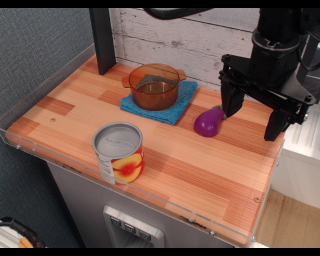

In [ ]:
Image.fromarray(sample[rlds.OBSERVATION]['image'].numpy()[0][-1])

In [ ]:
sample[rlds.OBSERVATION]['image'].shape

TensorShape([6, 15, 256, 320, 3])

observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
observation
obse

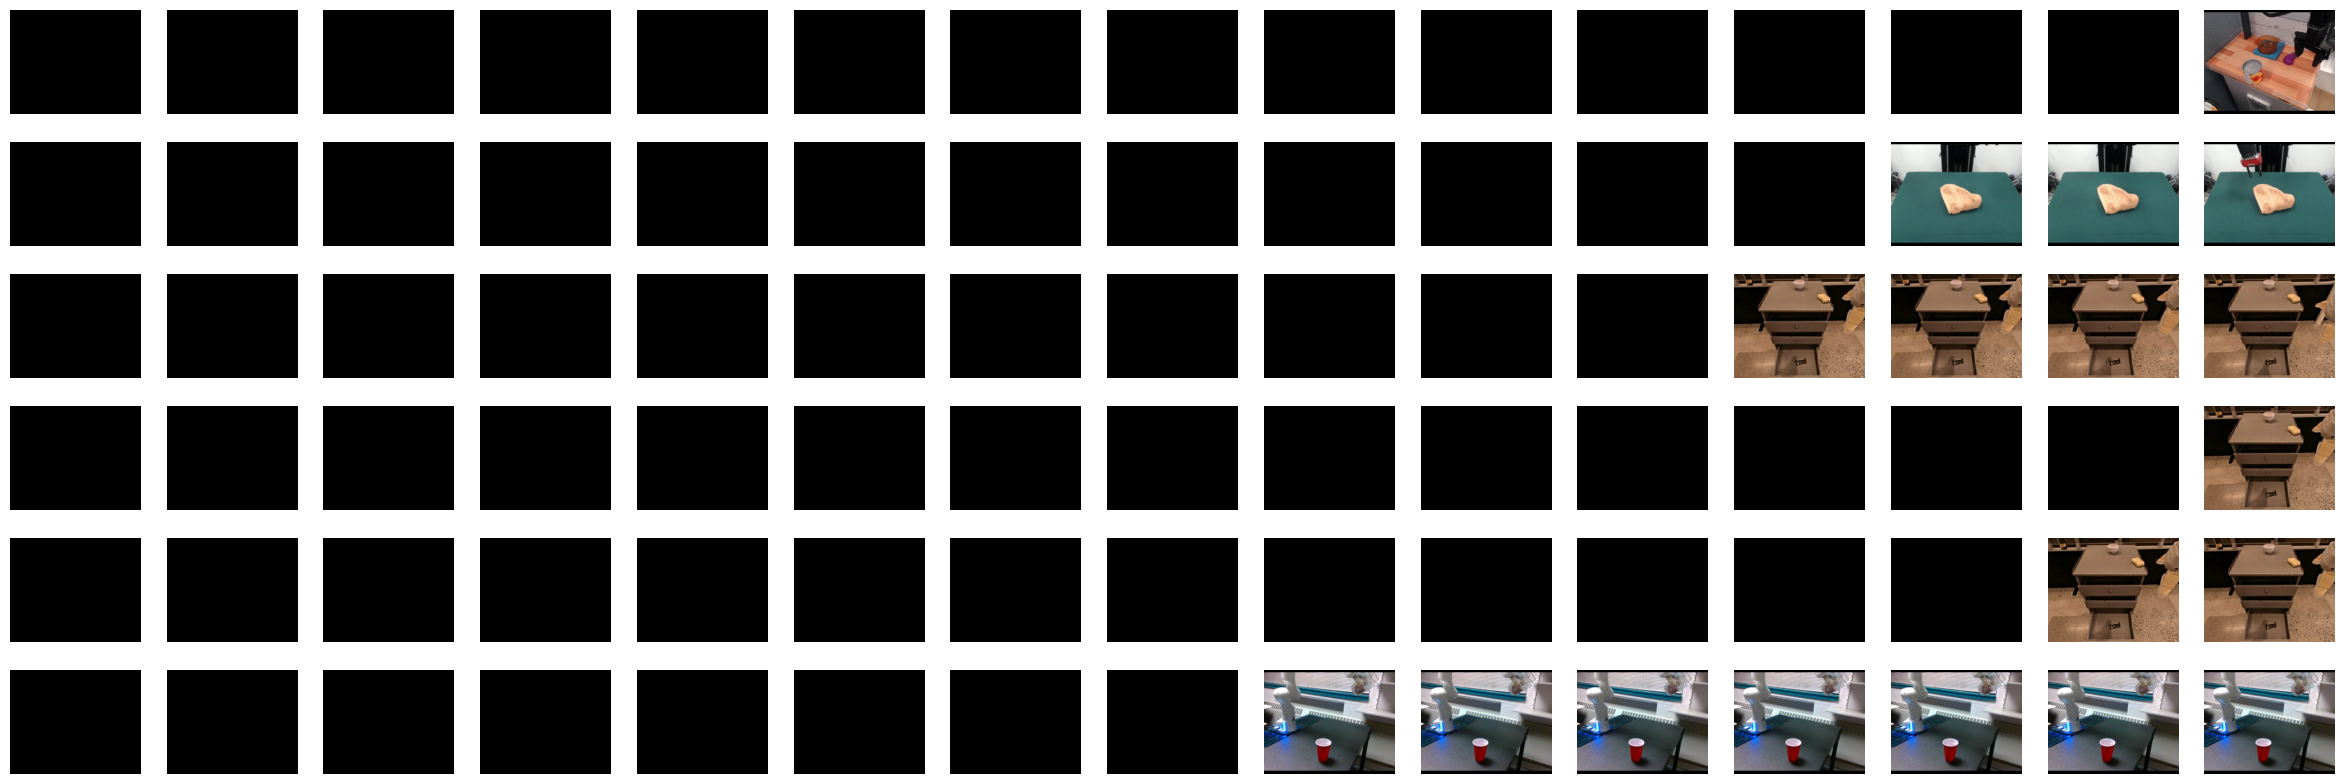

In [ ]:
# @title Visualize one batch of training data

batch_size = sample[rlds.OBSERVATION]['image'].shape[0]
trajectory_length = sample[rlds.OBSERVATION]['image'].shape[1]

fig, axs = plt.subplots(nrows=batch_size,
                        ncols=trajectory_length,
                        figsize=(30, 10))

for batch_index in range(batch_size):
  for trajectory_index in range(trajectory_length):
    print(rlds.OBSERVATION)
    axs[batch_index, trajectory_index].imshow(
        sample[rlds.OBSERVATION]['image'][batch_index, trajectory_index])
    axs[batch_index, trajectory_index].axis('off')

plt.show()

# RT-1 Model Code

In this section we:

* Add some model dependency code, which contains layers used by the RT-1 model including the FiLM layers and EfficientNet, as well as the main RT-1 flax module.
* Initialize random variables for the model and run a forward pass as an example.

In [ ]:
# @title Model dependencies code


MEAN_RGB = [0.485, 0.456, 0.406]
STDDEV_RGB = [0.229, 0.224, 0.225]


Initializer = Callable[[jnp.ndarray, Sequence[int], jnp.dtype], jnp.ndarray]


conv_kernel_init_fn = nn.initializers.variance_scaling(2.0, 'fan_out', 'normal')

dense_kernel_init_fn = nn.initializers.variance_scaling(
    1 / 3.0, 'fan_out', 'uniform'
)


class FilmConditioning(nn.Module):
  """FiLM conditioning layer."""

  num_channels: int

  @nn.compact
  def __call__(self, conv_filters, context):
    """Applies FiLM conditioning to the input.

    Args:
      conv_filters: array of shape (B, H, W, C), usually an output conv feature
        map.
      context: array of shape (B, context_size).

    Returns:
      array of shape (B, H, W, C) with the FiLM conditioning applied.
    """
    zero_init = nn.initializers.zeros_init()
    project_cond_add = nn.Dense(
        self.num_channels, kernel_init=zero_init, bias_init=zero_init
    )(context)
    project_cond_mul = nn.Dense(
        self.num_channels, kernel_init=zero_init, bias_init=zero_init
    )(context)

    project_cond_add = project_cond_add[:, None, None, :]
    project_cond_mul = project_cond_mul[:, None, None, :]

    result = (1 + project_cond_mul) * conv_filters + project_cond_add
    return result

class DepthwiseConv(nn.Module):
  """Depthwise convolution that matches tensorflow's conventions.

  In Tensorflow, the shapes of depthwise kernels don't match the shapes of a
  regular convolutional kernel of appropriate feature_group_count.
  It is safer to use this class instead of the regular Conv (easier port of
  tensorflow checkpoints, fan_out initialization of the previous layer will
  match the tensorflow behavior, etc...).

  Attributes:
    features: Number of convolution filters.
    kernel_size: Shape of the convolutional kernel.
    strides: A sequence of `n` integers, representing the inter-window strides.
    padding: Either the string `'SAME'`, the string `'VALID'`, or a sequence of
      `n` `(low, high)` integer pairs that give the padding to apply before and
      after each spatial dimension.
    input_dilation: `None`, or a sequence of `n` integers, giving the dilation
      factor to apply in each spatial dimension of `inputs`. Convolution with
      input dilation `d` is equivalent to transposed convolution with stride
      `d`.
    kernel_dilation: `None`, or a sequence of `n` integers, giving the dilation
      factor to apply in each spatial dimension of the convolution kernel.
      Convolution with kernel dilation is also known as 'atrous convolution'.
    feature_group_count: Unused attribute present in nn.Conv. Declare it to
      match the nn.Conv API.
    use_bias: Whether to add a bias to the output (default: True).
    dtype: The dtype of the computation (default: float32).
    precision: Numerical precision of the computation see `jax.lax.Precision`
      for details.
    kernel_init: Initializer for the convolutional kernel.
    bias_init: Initializer for the bias.
  """

  features: int
  kernel_size: Tuple[int, int]
  strides: Optional[Tuple[int, int]] = None
  padding: Union[str, Sequence[int]] = 'SAME'
  input_dilation: Optional[Sequence[int]] = None
  kernel_dilation: Optional[Sequence[int]] = None
  feature_group_count: int = 1
  use_bias: bool = True
  dtype: jnp.dtype = jnp.float32
  precision: Any = None
  kernel_init: Any = nn.initializers.lecun_normal()
  bias_init: Any = nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
    """Applies a convolution to the inputs.

    Args:
      inputs: Input data with dimensions (batch, spatial_dims..., features).

    Returns:
      The convolved data.
    """
    inputs = jnp.asarray(inputs, self.dtype)
    in_features = inputs.shape[-1]
    strides = self.strides

    if strides is None:
      strides = (1,) * (inputs.ndim - 2)

    kernel_shape = self.kernel_size + (self.features, 1)
    # Naming convention follows tensorflow.
    kernel = self.param('depthwise_kernel', self.kernel_init, kernel_shape)
    kernel = jnp.asarray(kernel, self.dtype)

    # Need to transpose to convert tensorflow-shaped kernel to lax-shaped kernel
    kernel = jnp.transpose(kernel, [0, 1, 3, 2])

    dimension_numbers = nn.linear._conv_dimension_numbers(inputs.shape)  # pylint:disable=protected-access

    y = jax.lax.conv_general_dilated(
        inputs,
        kernel,
        strides,
        self.padding,
        lhs_dilation=self.input_dilation,
        rhs_dilation=self.kernel_dilation,
        dimension_numbers=dimension_numbers,
        feature_group_count=in_features,
        precision=self.precision,
    )

    if self.use_bias:
      bias = self.param('bias', self.bias_init, (self.features,))
      bias = jnp.asarray(bias, self.dtype)
      y = y + bias

    return y


# pytype: disable=attribute-error
# pylint:disable=unused-argument
class BlockConfig(object):
  """Class that contains configuration parameters for a single block."""

  def __init__(
      self,
      input_filters: int = 0,
      output_filters: int = 0,
      kernel_size: int = 3,
      num_repeat: int = 1,
      expand_ratio: int = 1,
      strides: Tuple[int, int] = (1, 1),
      se_ratio: Optional[float] = None,
      id_skip: bool = True,
      fused_conv: bool = False,
      conv_type: str = 'depthwise',
  ):
    for arg in locals().items():
      setattr(self, *arg)


class ModelConfig(object):
  """Class that contains configuration parameters for the model."""

  def __init__(
      self,
      width_coefficient: float = 1.0,
      depth_coefficient: float = 1.0,
      resolution: int = 224,
      dropout_rate: float = 0.2,
      blocks: Tuple[BlockConfig, ...] = (
          # (input_filters, output_filters, kernel_size, num_repeat,
          #  expand_ratio, strides, se_ratio)
          # pylint: disable=bad-whitespace
          BlockConfig(32, 16, 3, 1, 1, (1, 1), 0.25),
          BlockConfig(16, 24, 3, 2, 6, (2, 2), 0.25),
          BlockConfig(24, 40, 5, 2, 6, (2, 2), 0.25),
          BlockConfig(40, 80, 3, 3, 6, (2, 2), 0.25),
          BlockConfig(80, 112, 5, 3, 6, (1, 1), 0.25),
          BlockConfig(112, 192, 5, 4, 6, (2, 2), 0.25),
          BlockConfig(192, 320, 3, 1, 6, (1, 1), 0.25),
          # pylint: enable=bad-whitespace
      ),
      stem_base_filters: int = 32,
      top_base_filters: int = 1280,
      activation: str = 'swish',
      batch_norm: str = 'default',
      bn_momentum: float = 0.99,
      bn_epsilon: float = 1e-3,
      # While the original implementation used a weight decay of 1e-5,
      # tf.nn.l2_loss divides it by 2, so we halve this to compensate in Keras
      weight_decay: float = 5e-6,
      drop_connect_rate: float = 0.2,
      depth_divisor: int = 8,
      min_depth: Optional[int] = None,
      use_se: bool = True,
      input_channels: int = 3,
      num_classes: int = 1000,
      model_name: str = 'efficientnet',
      rescale_input: bool = True,
      data_format: str = 'channels_last',
      final_projection_size: int = 0,
      classifier_head: bool = True,
      dtype: jnp.dtype = jnp.float32,
  ):
    """Default Config for Efficientnet-B0."""
    for arg in locals().items():
      setattr(self, *arg)


# pylint:enable=unused-argument


EN_MODEL_CONFIGS = {
    # (width, depth, resolution, dropout)
    'efficientnet-b3': ModelConfig(1.2, 1.4, 300, 0.3),
}


def round_filters(filters: int, config: ModelConfig) -> int:
  """Returns rounded number of filters based on width coefficient."""
  width_coefficient = config.width_coefficient
  min_depth = config.min_depth
  divisor = config.depth_divisor

  if not width_coefficient:
    return filters

  filters *= width_coefficient
  min_depth = min_depth or divisor
  new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
  # Make sure that round down does not go down by more than 10%.
  if new_filters < 0.9 * filters:
    new_filters += divisor
  return int(new_filters)


def round_repeats(repeats: int, depth_coefficient: float) -> int:
  """Returns rounded number of repeats based on depth coefficient."""
  return int(math.ceil(depth_coefficient * repeats))


def conv2d(
    inputs: jnp.ndarray,
    num_filters: int,
    config: ModelConfig,
    kernel_size: Union[int, Tuple[int, int]] = (1, 1),
    strides: Tuple[int, int] = (1, 1),
    use_batch_norm: bool = True,
    use_bias: bool = False,
    activation: Any = None,
    depthwise: bool = False,
    train: bool = True,
    conv_name: Optional[str] = None,
    bn_name: Optional[str] = None,
    dtype: jnp.dtype = jnp.float32,
) -> jnp.ndarray:
  """Convolutional layer with possibly batch norm and activation.

  Args:
    inputs: Input data with dimensions (batch, spatial_dims..., features).
    num_filters: Number of convolution filters.
    config: Configuration for the model.
    kernel_size: Size of the kernel, as a tuple of int.
    strides: Strides for the convolution, as a tuple of int.
    use_batch_norm: Whether batch norm should be applied to the output.
    use_bias: Whether we should add bias to the output of the first convolution.
    activation: Name of the activation function to use.
    depthwise: If true, will use depthwise convolutions.
    train: Whether the model should behave in training or inference mode.
    conv_name: Name to give to the convolution layer.
    bn_name: Name to give to the batch norm layer.
    dtype: dtype for the computation.

  Returns:
    The output of the convolutional layer.
  """
  conv_fn = DepthwiseConv if depthwise else nn.Conv
  kernel_size = (
      (kernel_size, kernel_size)
      if isinstance(kernel_size, int)
      else tuple(kernel_size)
  )
  conv_name = conv_name if conv_name else 'conv2d'
  bn_name = bn_name if bn_name else 'batch_normalization'

  x = conv_fn(
      num_filters,
      kernel_size,
      tuple(strides),
      padding='SAME',
      use_bias=use_bias,
      kernel_init=conv_kernel_init_fn,
      name=conv_name,
      dtype=dtype,
  )(inputs)

  if use_batch_norm:
    x = nn.BatchNorm(
        use_running_average=not train,
        momentum=config.bn_momentum,
        epsilon=config.bn_epsilon,
        name=bn_name,
        dtype=dtype,
    )(x)

  if activation is not None:
    x = getattr(nn.activation, activation.lower())(x)
  return x


def stochastic_depth(
    inputs: jnp.ndarray,
    rng: jnp.ndarray,
    survival_probability: float,
    deterministic: bool = False,
) -> jnp.ndarray:
  """Applies stochastic depth.

  Args:
    inputs: The inputs that should be randomly masked.
    rng: A `jax.random.PRNGKey`.
    survival_probability: 1 - the probability of masking out a value.
    deterministic: If false the inputs are scaled by `1 / (1 - rate)` and
      masked, whereas if true, no mask is applied and the inputs are returned as
      is.

  Returns:
    The masked inputs.
  """
  if survival_probability == 1.0 or deterministic:
    return inputs

  mask_shape = [inputs.shape[0]] + [1 for _ in inputs.shape[1:]]
  mask = jax.random.bernoulli(rng, p=survival_probability, shape=mask_shape)
  mask = jnp.tile(mask, [1] + list(inputs.shape[1:]))
  return jax.lax.select(
      mask, inputs / survival_probability, jnp.zeros_like(inputs)
  )


class SqueezeExcite(nn.Module):
  """SqueezeExite block (See: https://arxiv.org/abs/1709.01507.)

  Attributes:
    num_filters: Number of convolution filters.
    block: Configuration for this block.
    config: Configuration for the model.
    train: Whether the model is in training or inference mode.
  """

  num_filters: int
  block: BlockConfig
  config: ModelConfig
  train: bool

  @nn.compact
  def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
    """Applies a convolution to the inputs.

    Args:
      inputs: Input data with dimensions (batch, spatial_dims..., features).

    Returns:
      The output of the squeeze excite block.
    """
    block = self.block
    config = self.config
    train = self.train
    dtype = config.dtype
    num_reduced_filters = max(1, int(block.input_filters * block.se_ratio))

    se = nn.avg_pool(inputs, inputs.shape[1:3])
    se = conv2d(
        se,
        num_reduced_filters,
        config,
        use_bias=True,
        use_batch_norm=False,
        activation=config.activation,
        conv_name='reduce_conv2d_0',
        train=train,
        dtype=dtype,
    )

    se = conv2d(
        se,
        self.num_filters,
        config,
        use_bias=True,
        use_batch_norm=False,
        activation='sigmoid',
        conv_name='expand_conv2d_0',
        train=train,
        dtype=dtype,
    )

    return inputs * se


class MBConvBlock(nn.Module):
  """Main building component of Efficientnet.

  Attributes:
    block: BlockConfig, arguments to create a Block.
    config: ModelConfig, a set of model parameters.
    train: Whether we are training or predicting.
  """

  block: BlockConfig
  config: ModelConfig
  train: bool = False

  @nn.compact
  def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
    """Mobile Inverted Residual Bottleneck.

    Args:
      inputs: Input to the block.

    Returns:
      The output of the block.
    """
    config = self.config
    block = self.block
    train = self.train
    use_se = config.use_se
    activation = config.activation
    drop_connect_rate = config.drop_connect_rate
    use_depthwise = block.conv_type != 'no_depthwise'
    dtype = config.dtype

    rng = self.make_rng('random')

    filters = block.input_filters * block.expand_ratio

    x = inputs
    bn_index = 0

    if block.fused_conv:
      # If we use fused mbconv, skip expansion and use regular conv.
      x = conv2d(
          x,
          filters,
          config,
          kernel_size=block.kernel_size,
          strides=block.strides,
          activation=activation,
          conv_name='fused_conv2d_0',
          bn_name='batch_normalization_' + str(bn_index),
          train=train,
          dtype=dtype,
      )
      bn_index += 1
    else:
      if block.expand_ratio != 1:
        # Expansion phase
        kernel_size = (1, 1) if use_depthwise else (3, 3)
        x = conv2d(
            x,
            filters,
            config,
            kernel_size=kernel_size,
            activation=activation,
            conv_name='expand_conv2d_0',
            bn_name='batch_normalization_' + str(bn_index),
            train=train,
            dtype=dtype,
        )
        bn_index += 1
      # Depthwise Convolution
      if use_depthwise:
        x = conv2d(
            x,
            num_filters=x.shape[-1],  # Depthwise conv
            config=config,
            kernel_size=block.kernel_size,
            strides=block.strides,
            activation=activation,
            depthwise=True,
            conv_name='depthwise_conv2d',
            bn_name='batch_normalization_' + str(bn_index),
            train=train,
            dtype=dtype,
        )
        bn_index += 1

    # Squeeze and Excitation phase
    if use_se:
      assert block.se_ratio is not None
      assert 0 < block.se_ratio <= 1
      x = SqueezeExcite(
          num_filters=filters, block=block, config=config, train=train
      )(x)

    # Output phase
    x = conv2d(
        x,
        block.output_filters,
        config,
        activation=None,
        conv_name='project_conv2d_0',
        bn_name='batch_normalization_' + str(bn_index),
        train=train,
        dtype=dtype,
    )

    if (
        block.id_skip
        and all(s == 1 for s in block.strides)
        and block.input_filters == block.output_filters
    ):
      if drop_connect_rate and drop_connect_rate > 0:
        survival_probability = 1 - drop_connect_rate
        x = stochastic_depth(
            x, rng, survival_probability, deterministic=not train
        )
      x = x + inputs

    return x


class Stem(nn.Module):
  """Initial block of Efficientnet.

  Attributes:
    config: ModelConfig, a set of model parameters.
    train: Whether we are training or predicting.
  """

  config: ModelConfig
  train: bool = False

  @nn.compact
  def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
    """Returns the output of the stem block.

    Args:
      inputs: The input to the block.

    Returns:
      Output of the block
    """
    config = self.config
    train = self.train
    x = conv2d(
        inputs,
        round_filters(config.stem_base_filters, config),
        config,
        kernel_size=(3, 3),
        strides=(2, 2),
        activation=config.activation,
        train=train,
        dtype=config.dtype,
    )
    return x


class Head(nn.Module):
  """Final block of Efficientnet.

  Attributes:
    config: A set of model parameters.
    train: Whether we are training or predicting.
  """

  config: Any
  train: bool = True

  @nn.compact
  def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
    """Returns the output of the head block.

    Args:
      inputs: The input to the block.

    Returns:
      x: Classifier logits.
    """
    config = self.config
    train = self.train
    dtype = config.dtype
    # Build top.
    x = conv2d(
        inputs,
        round_filters(config.top_base_filters, config),
        config,
        activation=config.activation,
        train=train,
        dtype=dtype,
    )
    return x
# pytype: enable=attribute-error


class EfficientNetWithFilm(nn.Module):
  """EfficientNet with FiLM conditioning."""

  config: Any
  dtype: jnp.dtype = jnp.float32

  @nn.compact
  def __call__(
      self, inputs: jnp.ndarray, context_input: jnp.ndarray, *, train: bool
  ):
    """Returns the output of the EfficientNet model."""
    config = copy.deepcopy(self.config)
    config.dtype = self.dtype
    depth_coefficient = config.depth_coefficient
    blocks = config.blocks
    drop_connect_rate = config.drop_connect_rate

    inputs = jnp.asarray(inputs, self.dtype)

    # Build stem.
    x = Stem(config=config, train=train)(inputs)

    # Build blocks.
    num_blocks_total = sum(
        round_repeats(block.num_repeat, depth_coefficient) for block in blocks
    )
    block_num = 0

    for _, block in enumerate(blocks):
      assert block.num_repeat > 0
      # Update block input and output filters based on depth multiplier.
      block.input_filters = round_filters(block.input_filters, config)
      block.output_filters = round_filters(block.output_filters, config)
      block.num_repeat = round_repeats(block.num_repeat, depth_coefficient)

      # The first block needs to take care of stride and filter size increase
      drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
      config.drop_connect_rate = drop_rate

      x = MBConvBlock(block=block, config=config, train=train)(x)

      x = FilmConditioning(num_channels=x.shape[-1])(
          x, context_input
      )

      block_num += 1
      if block.num_repeat > 1:
        block.input_filters = block.output_filters
        block.strides = [1, 1]

        for _ in range(block.num_repeat - 1):
          drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
          config.drop_connect_rate = drop_rate
          x = MBConvBlock(block=block, config=config, train=train)(x)
          x = FilmConditioning(num_channels=x.shape[-1])(
              x, context_input
          )

          block_num += 1

    x = Head(self.config, train=train)(x)

    return x


class IdentityLayer(nn.Module):
  """Identity layer, convenient for giving a name to an array."""

  @nn.compact
  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    return x


class MlpBlock(nn.Module):
  """Transformer MLP / feed-forward block."""

  mlp_dim: int
  out_dim: Optional[int] = None
  dropout_rate: float = 0.1
  use_bias: bool = True
  kernel_init: Initializer = nn.initializers.xavier_uniform()
  bias_init: Initializer = nn.initializers.normal(stddev=1e-6)
  activation_fn: Callable[[jnp.ndarray], jnp.ndarray] = nn.gelu
  precision: Optional[jax.lax.Precision] = None
  dtype: jnp.ndarray = jnp.float32

  @nn.compact
  def __call__(self, inputs: jnp.ndarray, *, deterministic: bool):
    """Applies Transformer MlpBlock module."""
    actual_out_dim = inputs.shape[-1] if self.out_dim is None else self.out_dim
    x = nn.Dense(
        self.mlp_dim,
        dtype=self.dtype,
        use_bias=self.use_bias,
        kernel_init=self.kernel_init,
        bias_init=self.bias_init,
        precision=self.precision)(
            inputs)
    x = IdentityLayer(name='mlp1')(self.activation_fn(x))
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=deterministic)
    output = nn.Dense(
        actual_out_dim,
        dtype=self.dtype,
        use_bias=self.use_bias,
        kernel_init=self.kernel_init,
        bias_init=self.bias_init,
        precision=self.precision)(
            x)
    output = IdentityLayer(name='mlp2')(output)
    output = nn.Dropout(rate=self.dropout_rate)(
        output, deterministic=deterministic)
    return output


class TokenLearnerModuleV11(nn.Module):
  """TokenLearner module Version 1.1, using slightly different conv. layers.

  Instead of using 4 conv. layers with small channels to implement spatial
  attention, this version uses a MLP with gelu inbetween. It also uses softmax
  instead of sigmoid. We confirmed that this version works better in general.

  Attributes:
    num_tokens: Number of tokens.
    bottleneck_dim: The size of hidden units in the MLP for spatial attention.
    dropout_rate: Dropout rate.
  """
  num_tokens: int
  bottleneck_dim: int = 64
  dropout_rate: float = 0.

  @nn.compact
  def __call__(self, inputs: jnp.ndarray, deterministic: bool) -> jnp.ndarray:
    """Applies learnable tokenization to the 2D inputs.

    Args:
      inputs: Inputs of shape `[bs, h, w, c]`.
      deterministic: Weather we are in the deterministic mode (e.g inference
        time) or not.

    Returns:
      Output of shape `[bs, n_token, c]`.
    """
    if inputs.ndim == 4:
      n, h, w, c = inputs.shape
      inputs = jnp.reshape(inputs, [n, h*w, c])

    feature_shape = inputs.shape

    selected = inputs

    selected = nn.LayerNorm()(selected)

    selected = MlpBlock(
        mlp_dim=self.bottleneck_dim,
        out_dim=self.num_tokens,
        dropout_rate=self.dropout_rate,
        activation_fn=nn.gelu,
        name='token_masking')(
            selected, deterministic=deterministic)

    selected = jnp.reshape(
        selected,
        [feature_shape[0], -1, self.num_tokens])  # Shape: [bs, h*w, n_token].
    selected = jnp.transpose(selected, [0, 2, 1])  # Shape: [bs, n_token, h*w].
    selected = jax.nn.softmax(selected, axis=-1)

    feat = inputs
    feat = jnp.reshape(
        feat, [feature_shape[0], -1, feature_shape[-1]])  # Shape: [bs, h*w, c].

    feat = jnp.einsum('...si,...id->...sd', selected, feat)

    return feat


class FFNOptions(enum.Enum):
  """Different choices of FFN block for ablation testing."""

  LINEAR = 'linear'  # RT-1 Legacy
  SWIGLU = 'swiglu'  # Match LLaMa


class TransformerBlock(nn.Module):
  """A self-attention transformer block.

  See the `_TransformerLayer` in
  google-research/robotics_transformer/transformer.py for the original
  tensorflow implementation.
  """
  layer_size: int = 128
  num_heads: int = 8
  feed_forward_hidden_size: int = 512
  feed_forward_output_size: int = 512
  ffn_option: FFNOptions = FFNOptions.SWIGLU
  dropout_rate: float = 0.1

  @nn.compact
  def __call__(self, x: jnp.ndarray, attn_mask: jnp.ndarray, *, train: bool):
    x1 = nn.LayerNorm()(x)

    x1 = nn.MultiHeadDotProductAttention(
        num_heads=self.num_heads,
        qkv_features=(self.layer_size * self.num_heads),
        dropout_rate=self.dropout_rate,
    )(x1, x1, mask=attn_mask, deterministic=not train)

    x = x + x1

    y = nn.LayerNorm()(x)

    if self.ffn_option == FFNOptions.SWIGLU:
      h1 = nn.Dense(self.feed_forward_hidden_size, use_bias=False)(y)
      h1 = nn.swish(h1)
      gate = nn.Dense(self.feed_forward_hidden_size, use_bias=False)(y)
      ff_y = nn.Dense(self.feed_forward_output_size, use_bias=False)(h1 * gate)
    elif self.ffn_option == FFNOptions.LINEAR:
      ff_y = nn.Dense(self.feed_forward_output_size, use_bias=False)(y)
    else:
      raise ValueError(f'Unknown FFN option: {self.ffn_option}')

    ff_y = nn.Dropout(self.dropout_rate)(ff_y, deterministic=not train)
    x = x + ff_y
    return x


class Transformer(nn.Module):
  """Transformer architecture with dense positional embedding.

  See the `Transformer` in
  google-research/robotics_transformer/transformer.py for the original
  tensorflow implementation.
  """

  num_layers: int = 8
  layer_size: int = 128
  num_heads: int = 8
  feed_forward_hidden_size: int = 512
  feed_forward_output_size: int = 512
  ffn_option: FFNOptions = FFNOptions.SWIGLU
  dropout_rate: float = 0.1
  vocab_size: int = 256

  @nn.compact
  def __call__(self, x: jnp.ndarray, attn_mask: jnp.ndarray, *, train: bool):
    bs, seqlen, *_ = x.shape

    pos = jnp.expand_dims(jnp.arange(0, seqlen, 1), 0)
    pos = jnp.tile(pos, [bs, 1])
    pos = jax.nn.one_hot(pos, seqlen)

    x = nn.Dense(self.feed_forward_output_size)(x)
    pos_emb = nn.Dense(self.feed_forward_output_size)(pos)
    x += pos_emb

    for _ in range(self.num_layers):
      x = TransformerBlock(
          layer_size=self.layer_size,
          num_heads=self.num_heads,
          feed_forward_hidden_size=self.feed_forward_hidden_size,
          feed_forward_output_size=self.feed_forward_output_size,
          dropout_rate=self.dropout_rate,
          ffn_option=self.ffn_option,
      )(x, attn_mask, train=train)

    output_tokens = nn.Dense(self.vocab_size)(x)
    return output_tokens


class TokenLearnerModuleV11(nn.Module):
  """TokenLearner module Version 1.1, using slightly different conv. layers.

  Instead of using 4 conv. layers with small channels to implement spatial
  attention, this version uses a MLP with gelu inbetween. It also uses softmax
  instead of sigmoid. We confirmed that this version works better in general.

  From google-research/scenic/projects/token_learner/model.py.

  Attributes:
    num_tokens: Number of tokens.
    bottleneck_dim: The size of hidden units in the MLP for spatial attention.
    dropout_rate: Dropout rate.
  """
  num_tokens: int
  bottleneck_dim: int = 64
  dropout_rate: float = 0.

  @nn.compact
  def __call__(self, inputs: jnp.ndarray, deterministic: bool) -> jnp.ndarray:
    """Applies learnable tokenization to the 2D inputs.

    Args:
      inputs: Inputs of shape `[bs, h, w, c]`.
      deterministic: Weather we are in the deterministic mode (e.g inference
        time) or not.

    Returns:
      Output of shape `[bs, n_token, c]`.
    """
    if inputs.ndim == 4:
      n, h, w, c = inputs.shape
      inputs = jnp.reshape(inputs, [n, h*w, c])

    feature_shape = inputs.shape

    selected = inputs

    selected = nn.LayerNorm()(selected)

    selected = MlpBlock(
        mlp_dim=self.bottleneck_dim,
        out_dim=self.num_tokens,
        dropout_rate=self.dropout_rate,
        activation_fn=nn.gelu,
        name='token_masking')(
            selected, deterministic=deterministic)

    selected = jnp.reshape(
        selected,
        [feature_shape[0], -1, self.num_tokens])  # Shape: [bs, h*w, n_token].
    selected = jnp.transpose(selected, [0, 2, 1])  # Shape: [bs, n_token, h*w].
    selected = jax.nn.softmax(selected, axis=-1)

    feat = inputs
    feat = jnp.reshape(
        feat, [feature_shape[0], -1, feature_shape[-1]])  # Shape: [bs, h*w, c].

    feat = jnp.einsum('...si,...id->...sd', selected, feat)

    return feat


In [ ]:
# @title Main RT-1 model code

class ImageTokenizer(nn.Module):
  """Tokenizes images with EfficientNet+FiLM.

  This is based on the `RT1ImageTokenizer` implementation here:
  google-research/robotics_transformer/tokenizers/image_tokenizer.py

  The overall flow of the image tokenizer:
  * The input image batch dimensions are squashed, and the image is normalized.
  * The image is fed through the `EfficientNetWithFilm`.
  * A 1x1 convolution is applied to project to `num_features`.
  * Another final `FilmConditioning` layer is applied with the context.
  * `TokenLearnerModuleV11` is applied to project the tokens to `num_tokens`.
  """

  num_tokens: int = 8
  num_features: int = 512

  use_token_learner: bool = True

  @nn.compact
  def __call__(
      self, image: jnp.ndarray, context_input: jnp.ndarray, *, train: bool
  ):
    """Tokenizes the image using an EfficientNet.

    Args:
      image: jnp.Array with batch and seqlen leading dimensions. We assume the
        input image is of size 300x300, since the EfficientNet takes in images
        of that size.
      context_input: jnp.Array with shape (batch * seqlen, size).
      train: Training mode.

    Returns:
      shape (batch, seqlen, num_tokens, num_features) array.
    """
    bs, seqlen, *_ = image.shape

    # The efficientnet-b3 model uses 300x300 images.
    efficientnet_config = EN_MODEL_CONFIGS['efficientnet-b3']
    image = jnp.reshape(image, [bs * seqlen, 300, 300, 3])
    image -= jnp.array(MEAN_RGB)
    image /= jnp.array(STDDEV_RGB)

    # Apply film in EfficientNet.
    x = EfficientNetWithFilm(efficientnet_config)(
        image, context_input=context_input, train=train
    )

    # 1x1 conv. This corresponds to the 1x1 conv here:
    # google-research/robotics_transformer/film_efficientnet/pretrained_efficientnet_encoder.py
    var_init = nn.initializers.variance_scaling(
        scale=1.0,
        mode='fan_in',
        distribution='truncated_normal',
    )
    x = nn.Conv(
        features=self.num_features,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding='SAME',
        use_bias=False,
        kernel_init=var_init,
    )(x)

    x = FilmConditioning(num_channels=self.num_features)(
        x, context_input
    )

    if self.use_token_learner:
      x = TokenLearnerModuleV11(num_tokens=self.num_tokens)(
          x, deterministic=not train
      )

    x = jnp.reshape(x, [bs, seqlen, self.num_tokens, -1])

    return x


def tokenize_action(
    actions: Dict[str, jnp.ndarray],
    vocab_size: int,
    world_vector_range: Tuple[float, float] = (-1.0, 1.0),
) -> jnp.ndarray:
  """Tokenizes the action for the RT-1 task.

  <name>: <shape> <bounds>
  terminate_episode: (3,) int32,
    mode 0: terminate episode
    mode 1: arm + gripper

    mode 2: base
  world_vector: (3,) [-1.0, 1.0] (RT-1) or [-2.0, 2.0] (RT-1-X)
  rotation_delta: (3,) [-np.pi, np.pi]
  gripper_closedness_action: (1,) [-1, 1]
  base_displacement_vertical_rotation: (1,) [-np.pi, np.pi]
  base_displacement_vector: (2,) [-1.0, 1.0]

  Args:
    actions: The raw action dictionary.
    vocab_size: The vocab size of the tokenized actions.
    world_vector_range: The bounds to use for the world_vector token.

  Returns:
    the tokenized action.
  """
  action_tokens = []

  # Handle the discrete one first.
  terminate_episode = actions['terminate_episode']
  terminate_episode = jnp.argmax(terminate_episode, axis=-1)
  terminate_episode = jnp.expand_dims(terminate_episode, -1)
  terminate_episode = terminate_episode.astype(jnp.int32)
  action_tokens.append(terminate_episode)

  for act_name, act_min, act_max in [
      ('world_vector', world_vector_range[0], world_vector_range[1]),
      ('rotation_delta', -np.pi / 2, np.pi / 2),
      ('gripper_closedness_action', -1.0, 1.0),
      ('base_displacement_vertical_rotation', -np.pi, np.pi),
      ('base_displacement_vector', -1.0, 1.0),
  ]:
    act = actions[act_name]
    act = jnp.clip(act, act_min, act_max)
    act = (act - act_min) / (act_max - act_min)
    act = act * (vocab_size - 1)
    act = act.astype(jnp.int32)
    action_tokens.append(act)

  tokenized = jnp.concatenate(action_tokens, axis=-1)
  return tokenized


def detokenize_action(
    tokenized_actions: jnp.ndarray,
    vocab_size: int,
    world_vector_range: Tuple[float, float] = (-1.0, 1.0),
) -> Dict[str, jnp.ndarray]:
  """De-tokenizes the action for the RT-1 task.

  See `tokenize_action` for information on the action structure.

  Args:
    tokenized_actions: The tokenized action vector.
    vocab_size: The vocab size of the tokenized actions.
    world_vector_range: The bounds to use for the world_vector token.

  Returns:
    the detokenized action dictionary.
  """
  terminate_episode = tokenized_actions[:, 0]
  terminate_episode = jax.nn.one_hot(terminate_episode, 3)

  raw_actions = dict(
      world_vector=tokenized_actions[:, 1:4].astype(jnp.float32),
      rotation_delta=tokenized_actions[:, 4:7].astype(jnp.float32),
      gripper_closedness_action=tokenized_actions[:, 7:8].astype(jnp.float32),
      base_displacement_vertical_rotation=tokenized_actions[:, 8:9].astype(
          jnp.float32
      ),
      base_displacement_vector=tokenized_actions[:, 9:11].astype(jnp.float32),
  )

  act_dict = {'terminate_episode': terminate_episode.astype(jnp.int32)}
  for act_name, act_min, act_max in [
      ('world_vector', world_vector_range[0], world_vector_range[1]),
      ('rotation_delta', -np.pi / 2, np.pi / 2),
      ('gripper_closedness_action', -1.0, 1.0),
      ('base_displacement_vertical_rotation', -np.pi, np.pi),
      ('base_displacement_vector', -1.0, 1.0),
  ]:
    act = raw_actions[act_name]
    act = act / (vocab_size - 1)
    act = act * (act_max - act_min)
    act = act + act_min
    act_dict[act_name] = act

  return act_dict


class RT1(nn.Module):
  """Full RT-1 and RT-1-X architecture."""

  num_layers: int = 8
  layer_size: int = 128
  num_heads: int = 8
  feed_forward_hidden_size: int = 512
  feed_forward_output_size: int = 512
  ffn_option: FFNOptions = FFNOptions.SWIGLU
  dropout_rate: float = 0.1
  vocab_size: int = 256
  num_image_tokens: int = 8
  num_action_tokens: int = 11
  image_num_features: int = 512

  world_vector_range: Tuple[float, float] = (-1.0, 1.0)

  use_token_learner: bool = True

  # By default, mask out previous actions.
  include_prev_timesteps_actions: bool = False

  sow_intermediates: bool = False

  def setup(self):
    self.image_tokenizer = ImageTokenizer(
        num_tokens=self.num_image_tokens,
        num_features=self.image_num_features,
        use_token_learner=self.use_token_learner,
    )

  def tokenize_image(
      self, image: jnp.ndarray, context: jnp.ndarray, *, train: bool
  ):
    bs, seqlen, *_ = image.shape
    context = jnp.reshape(context, [bs * seqlen, -1])
    return self.image_tokenizer(image, context_input=context, train=train)

  @nn.compact
  def __call__(
      self,
      obs: Dict[str, jnp.ndarray],
      act: Dict[str, jnp.ndarray],
      obs_tokens: Optional[jnp.ndarray] = None,
      act_tokens: Optional[jnp.ndarray] = None,
      *,
      train: bool,
  ):
    bs = obs['image'].shape[0]
    seqlen = obs['image'].shape[1]

    # Depending on whether `obs_tokens` is passed, we either run the full
    # sequence of images through the image tokenizer, or simply use the
    # image tokens passed into this function. `obs_tokens` is usually passed
    # during an inference call when caching tokens from previous elements of
    # the input sequence.
    if obs_tokens is None:
      # Get image + language fused tokens.
      image = obs['image']
      lang = obs['natural_language_embedding']
      lang = jnp.reshape(lang, [bs * seqlen, -1])
      context_image_tokens = self.image_tokenizer(
          image=image, context_input=lang, train=train
      )
    else:
      context_image_tokens = obs_tokens

    if self.sow_intermediates:
      self.sow('intermediates', 'image_tokens', context_image_tokens)

    # We either tokenize the action ourselves using `tokenize_action_fn` or
    # use the tokens passed into this function. `act_tokens` is usually supplied
    # during an inference call when caching tokens from previous actions.
    if act_tokens is None:
      action_tokens = tokenize_action(
          act, self.vocab_size, self.world_vector_range
      )  # pylint: disable=too-many-function-args
    else:
      action_tokens = act_tokens

    if self.include_prev_timesteps_actions:
      # Always zero out the final action tokens.
      previous_action_tokens = action_tokens[:, : (seqlen - 1), :]
      zero_action_tokens = jnp.zeros((bs, 1, self.num_action_tokens))
      action_tokens = jnp.concatenate(
          [previous_action_tokens, zero_action_tokens], axis=-2
      )

      # Project the actions to the token dimension.
      action_tokens = jax.nn.one_hot(action_tokens, num_classes=self.vocab_size)
      action_tokens = nn.Dense(self.image_num_features)(action_tokens)
    else:
      # If we're not including the previous actions, then we can zero out
      # the action tokens. We do it here to ensure tokens are consistently
      # zero regardless of the input actions passed to the function.
      action_tokens = jnp.zeros(
          (bs, seqlen, self.num_action_tokens, self.image_num_features)
      )

    # Assemble the input tokens into a single sequence.
    full_tokens = jnp.concatenate(
        [context_image_tokens, action_tokens], axis=-2
    )

    num_action_tokens = action_tokens.shape[-2]
    full_tokens = jnp.reshape(
        full_tokens,
        [bs, seqlen * (self.num_image_tokens + num_action_tokens), -1],
    )

    attn_mask = self._construct_attn_mask(
        seqlen * (self.num_image_tokens + self.num_action_tokens)
    )
    output_tokens = Transformer(
        num_layers=self.num_layers,
        layer_size=self.layer_size,
        num_heads=self.num_heads,
        feed_forward_hidden_size=self.feed_forward_hidden_size,
        feed_forward_output_size=self.feed_forward_output_size,
        dropout_rate=self.dropout_rate,
        vocab_size=self.vocab_size,
        ffn_option=self.ffn_option,
    )(full_tokens, attn_mask=attn_mask, train=train)

    return output_tokens

  def _get_action_index_for_token(self, k: int, num_tokens: int):
    """Returns action associated with the token at given position `k`.

    If k is not an action token then it returns -1.
    If k is part of the first action in the sequence then returns 0 etc.

    Based on `_get_action_index_for_token` here:
    google-research/robotics_transformer/transformer_network.py

    Args:
      k: an int that represents the position in the sequence.
      num_tokens: The total number of tokens in the sequence.
    Returns:
      The index of the action that this position belongs to, or if this
      position is part of an image token then returns -1.
    """
    if k < 0 or k >= num_tokens:
      return -1

    single_time_step_num_tokens = self.num_image_tokens + self.num_action_tokens
    n = k
    if n % single_time_step_num_tokens < self.num_image_tokens:
      return -1

    return int(n / single_time_step_num_tokens)

  def _construct_attn_mask(self, num_tokens: ...):
    """Generate mask for action prediction loss.

    This masks out all action tokens.

    Based on `_generate_masks` here:
    google-research/robotics_transformer/transformer_network.py

    Args:
      num_tokens: The number of tokens with which to construct the input mask.

    Returns:
      A (num_tokens, num_tokens) attention mask.
    """
    default_attn_mask = np.tril(np.ones((num_tokens, num_tokens), np.int32))
    action_mask = np.zeros(shape=(num_tokens, num_tokens), dtype=np.int32)

    for i in range(num_tokens):
      for j in range(num_tokens):
        action_i = self._get_action_index_for_token(i, num_tokens)
        action_j = self._get_action_index_for_token(j, num_tokens)
        mask = 0
        if action_i != -1 and action_j != -1:
          # Ignore actions of previous steps.
          if action_j < action_i:
            mask = 1
          # If we're not auto-regression, ignore action dimensions of current
          # step.
          if action_j == action_i and j <= i:
            mask = 1
        # i not is an action, but j is an action token.
        # Hence, also mask j when predicting i, to prevent accidental
        # dependency between output and masked dimensions because the output
        # can still depend on the masked dimensions when predictions of the
        # transformer layers after the first layer depends on the masked
        # dimensions.
        elif action_j != -1:
          if not self.include_prev_timesteps_actions and j < i:
            mask = 1
        action_mask[i, j] = mask
    return default_attn_mask - action_mask



In [ ]:
SEQUENCE_LENGTH = 15
NUM_ACTION_TOKENS = 11
LAYER_SIZE = 256
VOCAB_SIZE = 512
NUM_IMAGE_TOKENS = 81

rt1x_model = RT1(
    num_image_tokens=NUM_IMAGE_TOKENS,
    num_action_tokens=NUM_ACTION_TOKENS,
    layer_size=LAYER_SIZE,
    vocab_size=VOCAB_SIZE,
    # Use token learner to reduce tokens per image to 81.
    use_token_learner=True,
    # RT-1-X uses (-2.0, 2.0) instead of (-1.0, 1.0).
    world_vector_range=(-2.0, 2.0)
)

# Initialize random weights for the model and run a forward pass.
obs = {
    "image": jnp.ones((1, 15, 300, 300, 3)),
    "natural_language_embedding": jnp.ones((1, 15, 512)),
}
act = {
    "world_vector": jnp.ones((1, 15, 3)),
    "rotation_delta": jnp.ones((1, 15, 3)),
    "gripper_closedness_action": jnp.ones((1, 15, 1)),
    "base_displacement_vertical_rotation": jnp.ones((1, 15, 1)),
    "base_displacement_vector": jnp.ones((1, 15, 2)),
    "terminate_episode": jnp.ones((1, 15, 3), dtype=jnp.int32),
}

variables = rt1x_model.init(
    {
        "params": jax.random.PRNGKey(0),
        "random": jax.random.PRNGKey(0),
    },
    obs,
    act,
    train=False,
)
model_output = rt1x_model.apply(
    variables,
    obs,
    act,
    train=False,
    rngs={"random": jax.random.PRNGKey(0)},
)

# Inspect the model weights and output.

param_count = sum(x.size for x in jax.tree_util.tree_leaves(variables["params"]))
print(f"Number of parameters: {param_count}")

print(f"Output shape: {model_output.shape}.")

# Extract the actions from the model.
time_step_tokens = (
    NUM_IMAGE_TOKENS + NUM_ACTION_TOKENS
)
output_logits = jnp.reshape(
    model_output, (1, SEQUENCE_LENGTH, time_step_tokens, -1)
)
action_logits = output_logits[:, -1, ...]
action_logits = action_logits[:, NUM_IMAGE_TOKENS - 1 : -1]

action_logp = jax.nn.softmax(action_logits)
action_token = jnp.argmax(action_logp, axis=-1)

action_detokenized = detokenize_action(action_token, VOCAB_SIZE, world_vector_range=(-2.0, 2.0))
print(f"Detokenized actions: {action_detokenized}")

Number of parameters: 56896809
Output shape: (1, 1380, 512).
Detokenized actions: {'terminate_episode': Array([[0, 0, 0]], dtype=int32), 'world_vector': Array([[ 0.48140907, -0.7475538 ,  1.9217222 ]], dtype=float32), 'rotation_delta': Array([[-0.5994232 , -0.71623397, -1.509317  ]], dtype=float32), 'gripper_closedness_action': Array([[-0.66340506]], dtype=float32), 'base_displacement_vertical_rotation': Array([[2.2685864]], dtype=float32), 'base_displacement_vector': Array([[-0.9608611,  0.5303327]], dtype=float32)}


# Training Setup and Loop

* First, add some additional preprocessors in the data pipeline. This crops and resizes images and filters out terminal steps from the episode.
* We set up the parallelism. We use a data parallel mesh and shard the batch across all of the available devices.
* Create the `create_train_state` and `train` functions. `create_train_state` initializes the train state, while `train` is the main step function called on each train iteration. `rt1_loss` implements the cross-entropy loss for the RT-1 model.
* We `jit` the functions above, and initialize the train state and place the input arrays on the available devices.
* Run the train loop which iterates through the batches and calls the train step.

In [ ]:
# @title Additional data preprocessing

def _is_not_terminal(trajectory):
  # -1 selects the final step in a trajectory
  if trajectory[rlds.IS_TERMINAL][-1]:
    return False
  return True


def convert_dtype_and_crop_images(
    images,
    resize_size,
    training: bool = True,
    convert_dtype: bool = True,
    seed: Optional[tf.Tensor] = None,
):
  """Convert uint8 images to float32 and square crop.

  Args:
    images: [B, H, W, 3] uint8 tensor of images.
    resize_size: (H, W) of resize.
    training: If we are in training (random crop) or not-training (fixed crop).
    convert_dtype: whether or not to convert the image to float32 in the range
      of (0, 1).
    seed: Optional seed of shape (2,) for giving to tf.random.stateless_uniform

  Returns:
    [B, crop_size, crop_size, 3] images of dtype float32.
  """

  if seed is None:
    seed = tf.random.uniform(shape=(2,), maxval=2**30, dtype=tf.int32)

  seed2 = tf.random.experimental.stateless_split(seed, num=1)[0]

  if convert_dtype:
    images = tf.image.convert_image_dtype(images, tf.float32)
  image_height = images.get_shape().as_list()[-3]
  image_width = images.get_shape().as_list()[-2]

  if training:
    if image_height == 512:
      ud_pad = 40
      lr_pad = 100
    elif image_height == 256:
      ud_pad = 20
      lr_pad = 50
    else:
      raise ValueError(
          'convert_dtype_and_crop_images only supports image height 512 or 256.'
      )
    max_y = 2 * ud_pad
    max_x = 2 * lr_pad
    images = tf.image.pad_to_bounding_box(
        images,
        offset_height=ud_pad,
        offset_width=lr_pad,
        target_height=image_height + 2 * ud_pad,
        target_width=image_width + 2 * lr_pad,
    )
    offset_y = tf.random.stateless_uniform(
        (), maxval=max_y + 1, dtype=tf.int32, seed=seed
    )
    offset_x = tf.random.stateless_uniform(
        (), maxval=max_x + 1, dtype=tf.int32, seed=seed2
    )
    images = tf.image.crop_to_bounding_box(
        images, offset_y, offset_x, image_height, image_width
    )

  # Add resize in pipeline for jax.
  images = tf.image.resize(images, size=resize_size)
  return images


def prepare_for_model_input(
    ds, target_height, target_width, training
):
  """Removes terminal trajectory, string from features and crops image."""
  ds = ds.filter(_is_not_terminal)

  # Remove non-jax types.
  def _remove_str(steps):
    if 'natural_language_instruction' in steps['observation']:
      del steps['observation']['natural_language_instruction']
    return steps

  ds = ds.map(_remove_str, num_parallel_calls=tf.data.AUTOTUNE)

  # Cropping augmentation.
  def _add_crop_augmentation(step):
    # Crop and pad augmentation. Added for jax.
    image = step['observation']['image']
    step['observation']['image'] = (
        convert_dtype_and_crop_images(
            image, (target_height, target_width), training=training
        )
    )
    return step

  ds = ds.map(_add_crop_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

  return ds

In [ ]:
# @title Set up sharding and data parallel mesh

# Actual global batch size is 1024. Use a smaller batch size for this colab
# example.
PER_DEVICE_BATCH_SIZE = 2

def reshard(tree, shardings):
  """Take an arbitrarily sharded pytree and shard it according to `shardings`.

  From `big_vision.utils.reshard`. See that doc for full details.

  Args:
    tree: a pytree of arrays.
    shardings: a (prefix) pytree of jax array shardings.

  Returns:
    A pytree of global jax arrays that follows provided shardings.
  """

  def _make_global_arr(x, shard, shape):
    # Avoid unnecessary copies and transfers:
    if hasattr(x, "sharding") and x.sharding.is_equivalent_to(
        shard, len(shape)
    ):  # pylint: disable=line-too-long
      return x
    if not getattr(x, "is_fully_addressable", True):
      raise RuntimeError(
          "Trying to reshard a non-fully-addressable array. "
          "Please see the doc-comment for detailed explanation."
      )
    x = jax.device_get(x)  # Might be on local devices.
    xs = [
        jax.device_put(x[s], device=d)
        for d, s in shard.addressable_devices_indices_map(shape).items()
    ]
    return jax.make_array_from_single_device_arrays(shape, shard, xs)

  shapes = jax.tree_map(np.shape, tree)
  shardings = tree_broadcast(shardings, tree)
  return jax.tree_map(_make_global_arr, tree, shardings, shapes)

def tree_broadcast(prefix, target):
  """Broadcasts a prefix tree to a full tree.

  See big_vision.utils.tree_broadcast.

  Args:
    prefix: prefix pytree.
    target: boradcast target for a prefix tree.

  Returns:
    prefix tree broadcasted to a target tree.
  """

  def _broadcast(leaf, subtree):
    return jax.tree_map(lambda _: leaf, subtree)

  return jax.tree_map(_broadcast, prefix, target)


NamedSharding = jax.sharding.NamedSharding
P = jax.sharding.PartitionSpec

# TODO: Replace this with an UMI dataset.
train_dataset = tf.data.Dataset.sample_from_datasets(datasets, weights=weights)

train_dataset = prepare_for_model_input(
    train_dataset, target_height=300, target_width=300, training=True
)

# Creating mesh and shardings.
num_devices = len(jax.devices())
mesh = jax.sharding.Mesh(
    mesh_utils.create_device_mesh((num_devices,)), ("data",)
)

# Data parallel mesh.
sharding = jax.sharding.NamedSharding(mesh, P("data"))
replicate_sharding = NamedSharding(mesh, P())

global_batch_size = jax.device_count() * PER_DEVICE_BATCH_SIZE
local_batch_size = jax.local_device_count() * PER_DEVICE_BATCH_SIZE
train_dataset = train_dataset.batch(local_batch_size, drop_remainder=True)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

train_iter = train_dataset.as_numpy_iterator()
sample_batch = jax.tree_map(lambda x: x, next(train_iter))

# shuffle and get new iterator for next epoch
def get_new_iterator():
  print("Shuffling dataset and getting new iterator.")
  shuffled_train_dataset = train_dataset.shuffle(10)
  shuffled_train_iter = shuffled_train_dataset.as_numpy_iterator()
  return shuffled_train_iter

print(f"Local batch size: {local_batch_size}")
print(f"Global batch size: {global_batch_size}")
print(f"Devices: {jax.devices()}")
print(f"Sample batch keys: {sample_batch.keys()}")

<class 'tensorflow.python.data.ops.directed_interleave_op._DirectedInterleaveDataset'>


/tmp/ipykernel_26805/3059540945.py:90: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  sample_batch = jax.tree_map(lambda x: x, next(train_iter))


Local batch size: 2
Global batch size: 2
Devices: [cuda(id=0)]
Sample batch keys: dict_keys(['action', 'is_first', 'is_last', 'is_terminal', 'observation'])


In [ ]:
# @title Create the train init fn, train step fn, and loss function.

@flax.struct.dataclass
class TrainState:
  step: int
  params: Any
  opt_state: optax.OptState
  batch_stats: Any

base_checkpoint_path = "/home/jonathan/Thesis/ROS2_RT-1-X/ros2_ws/src/ros2_rt_1_x/ros2_rt_1_x/checkpoints/rt_1_x_jax"
# base_checkpoint_path = "/home/jonathan/Thesis/open_x_embodiment/custom_rt1x_checkpoint_epoch10"
checkpoint_state_dict = checkpoints.restore_checkpoint(base_checkpoint_path, None)

# Create train state based on previously saved checkpoint.
def create_train_state_with_loaded_params(model, batch, rng, optimizer):

    train_state = TrainState(
        step=0,
        params=checkpoint_state_dict["params"],
        opt_state=optimizer.init(checkpoint_state_dict["params"]),
        batch_stats=checkpoint_state_dict["batch_stats"],
    )
    return train_state



def create_train_state(model, batch, rng, optimizer):
    """Creates the train state and initial metrics for agent."""
    obs_input = batch["observation"]
    act_input = batch["action"]

    rng, rng2, rng3 = jax.random.split(rng, 3)
    variables = model.init(
        {"params": rng, "random": rng3},
        obs=obs_input,
        act=act_input,
        train=False,
    )

    params = flax.core.unfreeze(variables["params"])
    batch_stats = flax.core.unfreeze(variables["batch_stats"])

    train_state = TrainState(
        step=0,
        params=flax.core.unfreeze(params),
        opt_state=optimizer.init(params),
        batch_stats=batch_stats,
    )
    return train_state


def train(batch, state, model, optimizer, rng):
  """Performs a single training step."""
  rng, loss_rng = jax.random.split(rng)

  def loss_fn(params):
    variables = {"params": params, "batch_stats": state.batch_stats}
    per_example_loss, new_variables = rt1_loss(
        model, batch=batch, variables=variables, rng=loss_rng
    )
    loss = jnp.mean(per_example_loss)
    return loss, new_variables["batch_stats"]

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, new_batch_stats), grad = grad_fn(state.params)

  loss = jnp.mean(loss)

  updates, new_opt_state = optimizer.update(
      grad, state.opt_state, state.params
  )

  new_params = optax.apply_updates(state.params, updates)
  new_state = state.replace(
      step=state.step + 1,
      params=flax.core.unfreeze(new_params),
      opt_state=flax.core.unfreeze(new_opt_state),
      batch_stats=flax.core.unfreeze(new_batch_stats),
  )

  metrics_update = {
      "loss": loss,
  }
  return new_state, metrics_update


def rt1_loss(
      model,
      batch,
      variables,
      rng,
  ):
  """Implements the RT-1 loss."""
  observation = batch["observation"]
  action = batch["action"]

  print(action)

  bs = observation["image"].shape[0]
  seqlen = observation["image"].shape[1]

  # First, we encode the observations using the model.encode method.
  # This will give us an observation encoding (for the entire sequence).
  rng, params_rng = jax.random.split(rng)
  rng, dropout_rng = jax.random.split(rng)
  rng, sd_rng = jax.random.split(rng)
  rng, random_rng = jax.random.split(rng)
  logits, new_variables = model.apply(
      variables,
      obs=observation,
      act=action,
      train=True,
      mutable=["batch_stats"],
      rngs={
          "params": params_rng,
          "dropout": dropout_rng,
          "random": random_rng,
      },
  )

  vocab_size = model.vocab_size

  # `action` is dict of (B, T, ...), we combine actions into B*T batch to
  # tokenize.
  action = jax.tree_map(lambda x: jnp.reshape(x, (bs * seqlen, -1)), action)
  labels = tokenize_action(action, vocab_size=vocab_size)
  labels = jax.tree_map(lambda x: jnp.reshape(x, (bs, seqlen, -1)), labels)
  labels = labels[:, :, :, None]  # labels should be (B, seqlen, 11, 1)

  # Get num_action_tokens tokens for the action prediction. By default,
  # RT-1 computes the loss for all `seqlen * num_action_tokens`, not just
  # the final timestep's action.
  # In the default RT-1 setup (8 img, 11 act tokens), we have:
  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
  # |-----image tokens------|-------------action tokens--------------|
  #                      |----------------logits------------------|
  # For each time step, we want [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] for
  # the logits, for the "next token" prediction.
  num_image_tokens = model.num_image_tokens
  num_action_tokens = model.num_action_tokens
  time_step_tokens = num_image_tokens + num_action_tokens
  logits = jnp.reshape(logits, (bs, seqlen, time_step_tokens, vocab_size))
  logits = logits[:, :, num_image_tokens - 1 : -1]

  logp = jax.nn.log_softmax(logits)
  loglik = jnp.take_along_axis(logp, labels, axis=-1)
  loglik = jnp.mean(loglik, axis=(1, 2, 3))

  return -loglik, new_variables

In [ ]:
# @title Set up the functions for training

optimizer = optax.adam(learning_rate=1e-4, eps=1e-7)

# Create the train state.
# input: batch, rng, ds_info
# output: state
agent_create_train_state = functools.partial(
    create_train_state, model=rt1x_model, optimizer=optimizer
)
create_train_state_jit = jax.jit(
    agent_create_train_state,
    out_shardings=replicate_sharding,
)

agent_create_train_state_with_loaded_params = functools.partial(
    create_train_state_with_loaded_params, model=rt1x_model, optimizer=optimizer
)
create_train_state_with_loaded_params_jit = jax.jit(
    agent_create_train_state_with_loaded_params,
    out_shardings=replicate_sharding,
)

global_data_shape = jax.tree_map(
    lambda x: (global_batch_size,) + x.shape[1:], sample_batch
)

local_devices = mesh.local_devices
local_device_count = jax.local_device_count()

def _put_to_devices(x):
  per_device_arrays = np.split(x, local_device_count, axis=0)
  return jax.device_put(per_device_arrays, local_devices)

def _form_gda(local_data, global_shape):
  arrays = _put_to_devices(local_data)
  return jax.make_array_from_single_device_arrays(
      global_shape, sharding, arrays
  )

rng = jax.random.PRNGKey(0)

sample_batch = jax.tree_map(_form_gda, sample_batch, global_data_shape)
rng, agent_rng = jax.random.split(rng)
# state = create_train_state_jit(
#     batch=sample_batch, rng=agent_rng
# )
state = create_train_state_with_loaded_params_jit(
    batch=sample_batch, rng=agent_rng
)

# Create the train step.
agent_train = functools.partial(train, model=rt1x_model, optimizer=optimizer)
jitted_train_step = jax.jit(
    agent_train,
    out_shardings=(replicate_sharding, replicate_sharding),
)

/tmp/ipykernel_26805/1945877674.py:24: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  global_data_shape = jax.tree_map(
/tmp/ipykernel_26805/1945877674.py:43: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  sample_batch = jax.tree_map(_form_gda, sample_batch, global_data_shape)


In [ ]:
# @title Run the train loop

num_train_steps = 1_000_000  # 1k for example, actual should be > 1M
log_loss_every_steps = 10
epoch_count = 1
epoch_step = 1


# The state should be resharded since we may have loaded pretrained weights
# that need to be converted to jax.Arrays.
state_repl = reshard(state, shardings=replicate_sharding)
# The RNG must be replicated.
rng_repl = reshard(rng, shardings=replicate_sharding)

train_iter = get_new_iterator()

for step in range(num_train_steps):
  is_last_step = step == num_train_steps

  rng_repl = jax.random.fold_in(rng_repl, step)

  # check if there is next in train_iter
  try:
    batch = next(train_iter)
    batch = jax.tree_map(_form_gda, batch, global_data_shape)
    epoch_step += 1
  except StopIteration:
    # Save the current state. If there are more than 10 checkpoints already saved, delete the oldest

    if epoch_count > 10:
      shutil.rmtree(f'/home/jonathan/Thesis/open_x_embodiment/custom_rt1x_checkpoint_epoch{epoch_count - 10}', ignore_errors=True)

    checkpoint_path = f'/home/jonathan/Thesis/open_x_embodiment/custom_rt1x_checkpoint_epoch{epoch_count}'
    checkpoints.save_checkpoint(ckpt_dir=checkpoint_path, target=state_repl, step=step, overwrite=True)
    print(f"Saved checkpoint after epoch {epoch_count}.")

    train_iter = get_new_iterator()
    epoch_count += 1
    epoch_step = 1
    batch = next(train_iter)
    batch = jax.tree_map(_form_gda, batch, global_data_shape)

  state_repl, metrics_update = jitted_train_step(
      state=state_repl, batch=batch, rng=rng_repl
  )

  if step % log_loss_every_steps == 0 or is_last_step:
    metrics_update = jax.device_get(metrics_update)
    print(f"Metrics: step={step} ({epoch_step}), epoch={epoch_count} {metrics_update}")

# Save the final trained state
checkpoint_path = '/home/jonathan/Thesis/open_x_embodiment/custom_rt1x_checkpoint_final'
checkpoints.save_checkpoint(ckpt_dir=checkpoint_path, target=state_repl, step=num_train_steps, overwrite=True)

/tmp/ipykernel_26805/2269640000.py:38: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  shapes = jax.tree_map(np.shape, tree)
/tmp/ipykernel_26805/2269640000.py:58: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(_broadcast, prefix, target)
/tmp/ipykernel_26805/2269640000.py:56: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda _: leaf, subtree)
/tmp/ipykernel_26805/2269640000.py:40: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(_make_global_arr, tree, shardings, shapes)


Shuffling dataset and getting new iterator.


/tmp/ipykernel_26805/90524454.py:25: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  batch = jax.tree_map(_form_gda, batch, global_data_shape)


{'base_displacement_vector': Traced<ShapedArray(float32[2,15,2])>with<DynamicJaxprTrace(level=1/0)>, 'base_displacement_vertical_rotation': Traced<ShapedArray(float32[2,15,1])>with<DynamicJaxprTrace(level=1/0)>, 'gripper_closedness_action': Traced<ShapedArray(float32[2,15,1])>with<DynamicJaxprTrace(level=1/0)>, 'rotation_delta': Traced<ShapedArray(float32[2,15,3])>with<DynamicJaxprTrace(level=1/0)>, 'terminate_episode': Traced<ShapedArray(int32[2,15,3])>with<DynamicJaxprTrace(level=1/0)>, 'world_vector': Traced<ShapedArray(float32[2,15,3])>with<DynamicJaxprTrace(level=1/0)>}


KeyboardInterrupt: 